In [325]:
import numpy as np
import scipy as sp
from pathlib2 import Path
import matplotlib.pyplot as plt

class Solver:
    def __init__(self, step=0.1):
        self.step = step
        self.ro_w = 1000 # kg/m^3
        self.mu_g = 44  # g/mol
        self.mu_v = 18  # g/mol
        self.mu_w = 18
        self.g = -9.8
        self.p0 = 10 ** 5  # Pa
        self.l = 2260 * 10 ** 3 # Dj/kg  ##  heat of vaporization
        self.eta_g = 3 * 10 ** -5 # Pa * sec
        self.kappa_g = 0.02 # W/m K

        self.eta = 0
        self.kappa = 10 ** 3 * 0.022
        self.xi_l = 0
        self.xi_v = 0

        self.c_v = 3 * 8.134 / 2 
        self.c_p = 5 * 8.134 / 2 
        self.c_vv = 3 * 8.134 / self.mu_v
        self.c_vg = (5 / 2) * 8.134 / self.mu_g
        self.c_pv = 4 * 8.134 / self.mu_v
        self.c_pg = (7 / 2) * 8.134 / self.mu_g
        self.c_l = 4.183  # heat capasity of the water
        

        self.v = 0
        self.r = 0
        self.t = 0
        self.ro_v = 0
        self.ro_l = 0
        self.ro_g = 0

        self.velocity = []
        self.radius = []
        self.temperature = []
        self.gas_density = []
        self.vap_density = []
        self.liq_density = []
        self.xi_l_hist = []
        self.xi_v_hist = []

    def set_initial_conditions(self, t=1, r=0, p=0, q=0, h=0):
        self.h = h
        self.ro_l = 0
        self.ro_v = 0
        self.t = t
        self.r = r
        self.ro_g = (p + self.ro_w * np.abs(self.g) * h) * self.mu_g / (8.3145 * self.t * 10 ** 3)
        self.v = q / (np.pi * self.r ** 2 * self.ro_g)
        
        print('INITIAL CONDITIONS:')
        print('ro_g: ', self.ro_g)
        print('v: ', self.v)
        print('ro_l: ', self.ro_l)
        print('ro_v: ', self.ro_v)
        print('T0: ', self.t)
        print('r: ', self.r)
        print('p: ', p)
        
        self.iter_num = int(self.h / self.step)

        self.velocity.append(self.v)
        self.radius.append(self.r)
        self.temperature.append(self.t)
        self.gas_density.append(self.ro_g)
        self.vap_density.append(self.ro_v)
        self.liq_density.append(self.ro_g)
        
    def _get_xi(self, indx):
        self.eta = 0.5 * self.ro_g * self.v ** 2 * 0.027 * (self.ro_g * self.v * (indx * self.step) / self.eta_g) ** (-1/7) #/ 10 ** 3
        self.kappa = 0.023 *  (self.ro_g * self.r * (indx * self.step) / self.eta_g) ** (4/5) * 0.02  # 0.022 for air termoconductivity
         
        A = np.array([[self.v, self.v],
                      [0.5 * self.v ** 2, 0.5 * self.v ** 2 + self.l * self.theta(self.t - self._get_t_boiling(indx))]])
        b = np.array([2 * np.pi * self.eta * self.v * self.r / self.r,
                      2 * np.pi * self.kappa * self.tay(self.t - self._get_t_boiling(indx)) * self.r / self.r])

        try:
            if self.t - self._get_t_boiling(indx) > 0:
                self.xi_l, self.xi_v = np.linalg.solve(A, b)
            else:
                self.xi_l = 2 * np.pi * self.r * self.eta / 8.3145 
                self.xi_v = 0
                print('EXCEPT')
        except:
            self.xi_l = 2 * np.pi * self.eta 
            self.xi_v = 0
            print('EXCEPT')
        
        if self.xi_l < 0 or self.xi_v < 0:
            self.xi_l = 2 * np.pi * self.r * self.eta / 8.3145 
            self.xi_v = 0
            print('EXCEPT')
        
        self.xi_l = 2 * np.pi * self.r * self.eta / 8.3145 
        self.xi_v = 0
        
        self.xi_l_hist.append(self.xi_l)
        self.xi_v_hist.append(self.xi_v)

        #print('Re: ', (self.ro_g * self.v * (indx * self.step) / self.eta_g))
        print('eta:', self.eta)
        print('kappa:', self.kappa)
        print('T: ', self.t)
        print("T boiling:", self._get_t_boiling(indx))
        print("tay:", self.tay(self.t - self._get_t_boiling(indx)))
        print("Xi_v:", self.xi_v)
        print("Xi_l:", self.xi_l)
        
        return [self.xi_v, self.xi_l]
        

    def _get_t_boiling(self, indx):
        return  (1/373 - 8.3145 * np.log((self.p0 + self.ro_w * np.abs(self.g) * (self.h - indx * self.step))/ self.p0)/ ( self.mu_w * 2260 * 10 **3)) ** -1

    def do_iteration(self, indx):
        self._get_xi(indx)
        
        
        A = np.array([[np.pi * self.ro_v * self.r ** 2, 2 * np.pi * self.ro_v * self.r * self.v, 0,
               np.pi * self.v * self.r ** 2, 0, 0],
              [np.pi * self.ro_l * self.r ** 2, 2 * np.pi * self.ro_l * self.r * self.v, 0,
               0, np.pi * self.v * self.r ** 2, 0],
              [2 * np.pi * self.r ** 2 * self._get_ro() * self.v, 2 * np.pi * self.r * self._get_ro() * self.v ** 2, 0,
               np.pi * self.r ** 2 * self.v ** 2 * self.c_vv / self.c_v, np.pi * self.r ** 2 * self.v ** 2 * self.c_l / self.c_v,
               np.pi * self.r ** 2 * self.v ** 2 * self.c_vg / self.c_v],
              [np.pi * self.r ** 2 * self.ro_g, 2 * np.pi * self.r * self.v * self.ro_g,
               0, 0, 0, np.pi * self.r ** 2 * self.v],
              [self.v, 0, self.c_p, 0, 0, 0],
              [0, 0, 8.314 * (self.ro_g / self.mu_g + self.ro_v / self.mu_v), 8.314 * self.t / self.mu_v, 0, 8.314 * self.t / self.mu_g]
            ])

        r_h_s = [self.xi_v, 
             self.xi_l, 
             np.pi * self.r ** 2 * np.abs(self.g) * (self.ro_w /10 ** 2 - self._get_ro()), 
             0,
             -self.g - ((self.l + self.c_pv * self.t)*self.xi_v + self.c_l * self.xi_l * self.t +
                        (self.xi_l + self.xi_v) * (0.5 * self.v ** 2 + np.abs(self.g) * indx * self.step))
             / (np.pi * self.r ** 2 * self._get_ro() * self.v), 
             self.ro_w * self.g / 10 ** 3]
        
        print(r_h_s, '\n')

        return np.linalg.solve(A, r_h_s)

    def make_time_iter(self):
        for indx in range(1, self.iter_num + 1):
            print("\nIteration #", indx)
            new_iteration = self.do_iteration(indx)
            
            print(np.array(new_iteration), '\n')
            
            self.v = self.v + new_iteration[0] * self.step
            self.r = self.r + new_iteration[1] * self.step
            self.t = self.t + new_iteration[2] * self.step 
            self.ro_v = self.ro_v + new_iteration[3] * self.step
            self.ro_l = self.ro_l + new_iteration[4] * self.step
            self.ro_g = self.ro_g + new_iteration[5] * self.step
            
            print('v', self.v)
            print('r', self.r)
            print('t', self.t)
            print('ro_v', self.ro_v)
            print('ro_l', self.ro_l)
            print('ro_g', self.ro_g)

            self.velocity.append(self.v)
            self.radius.append(self.r)
            self.temperature.append(self.t)
            self.gas_density.append(self.ro_g)
            self.vap_density.append(self.ro_v)
            self.liq_density.append(self.ro_l)

    def _get_ro(self):
        return (self.ro_g * self.c_vg + self.c_vv * self.ro_v + self.c_l * self.ro_l) / self.c_v

    @staticmethod
    def theta(x):
        if x <= 0:
            return 0
        else:
            return 1

    @staticmethod
    def tay(x):
        if x >= 0:
            return x
        else:
            return 0


In [326]:
s = Solver(0.1)
s.set_initial_conditions(t=1000, r=1, p=101325, q=100, h=50)

s.make_time_iter()

INITIAL CONDITIONS:
ro_g:  3.1292681460099825
v:  10.172023340015018
ro_l:  0
ro_v:  0
T0:  1000
r:  1
p:  101325

Iteration # 1
eta: 0.8368160018142882
kappa: 0.754075883042713
T:  1000
T boiling: 373.050432596316
tay: 626.949567403684
Xi_v: 0
Xi_l: 0.6323735651467077
[0, 0.6323735651467077, 304.2267360736766, 0, -697.3383125215013, -9.8] 

[ 7.97336513e+01 -3.94806368e+00 -7.41770777e+01 -1.67234951e-18
  1.97886645e-02  1.80255641e-01] 

v 18.14538847281751
r 0.6051936324252135
t 992.5822922310558
ro_v -1.6723495064729577e-19
ro_l 0.0019788664537923615
ro_g 3.1472937101242957

Iteration # 2
eta: 2.2313785639982067
kappa: 0.8825719558731404
T:  992.5822922310558
T boiling: 373.05038523237795
tay: 619.5319069986779
Xi_v: 0
Xi_l: 1.0204960717342186
[0, 1.0204960717342186, 111.41053186793229, 0, -1750.746676705405, -9.8] 

[ 4.19704070e+01 -7.32548859e-01 -1.23546399e+02 -2.37538589e-18
  4.90906751e-02  3.39490721e-01] 

v 22.342429175242124
r 0.5319387465369789
t 980.2276523661794
ro_

r 0.2788067294261451
t 423.0283846052593
ro_v -4.325153917324948e-18
ro_l 1.3597166880572928
ro_g 6.5703660390585314

Iteration # 62
EXCEPT
eta: 9.985494685805355
kappa: 13.34407373494022
T:  423.0283846052593
T boiling: 373.0473886003105
tay: 49.98099600494879
Xi_v: 0
Xi_l: 2.103858696414721
[0, 2.103858696414721, 22.220934129955335, 0, -802.2090248889606, -9.8] 

[-7.55539605e-01 -7.14373113e-03 -3.80488038e+01  2.44009488e-17
  3.25421029e-01  4.68361582e-01] 

v 37.62809350842527
r 0.27809235631314916
t 419.2235042217385
ro_v -1.8850590361937115e-18
ro_l 1.3922587909146626
ro_g 6.61720219722697

Iteration # 63
EXCEPT
eta: 9.986267301902714
kappa: 13.565132283795949
T:  419.2235042217385
T boiling: 373.04733588230636
tay: 46.17616833943214
Xi_v: 0
Xi_l: 2.0986304467043144
[0, 2.0986304467043144, 22.076420756457388, 0, -785.894678929378, -9.8] 

[-7.50825988e-01 -6.98346846e-03 -3.72580540e+01 -1.23543510e-17
  3.27265654e-01  4.64381767e-01] 

v 37.553010909637585
r 0.27739400946674

Iteration # 118
EXCEPT
eta: 9.679535178498943
kappa: 25.89783680122934
T:  286.6621457241933
T boiling: 373.0442747590661
tay: 0
Xi_v: 0
Xi_l: 1.861383159843518
[0, 1.861383159843518, 16.977878246684405, 0, -332.30118337689237, -9.8] 

[-4.73705562e-01 -2.48393781e-03 -1.55425778e+01  9.97217843e-18
  3.79239348e-01  2.88846377e-01] 

v 34.24157235090095
r 0.2542221672171569
t 285.10788794004316
ro_v -1.6507790813298525e-17
ro_l 3.4093753397109037
ro_g 8.693190453963494

Iteration # 119
EXCEPT
eta: 9.670631762980639
kappa: 26.122364549351836
T:  285.10788794004316
T boiling: 373.04421593664466
tay: 0
Xi_v: 0
Xi_l: 1.8578557632636967
[0, 1.8578557632636967, 16.916701770889517, 0, -328.2959512244383, -9.8] 

[-4.69811861e-01 -2.44110868e-03 -1.53532754e+01 -0.00000000e+00
  3.79481595e-01  2.86223654e-01] 

v 34.1945911648344
r 0.25397805634867004
t 283.57256040423715
ro_v -1.6507790813298525e-17
ro_l 3.4473234991646913
ro_g 8.721812819389728

Iteration # 120
EXCEPT
eta: 9.66166352976667

r 0.24626923314752974
t 226.58077458594403
ro_v 1.0563654399590881e-17
ro_l 5.261056860542398
ro_g 9.811063569634737

Iteration # 168
EXCEPT
eta: 9.175354796189808
kappa: 36.9665781465999
T:  226.58077458594403
T boiling: 373.04117362191397
tay: 0
Xi_v: 0
Xi_l: 1.7075630773259884
[0, 1.7075630773259884, 14.610395376697587, 0, -198.5675200404188, -9.8] 

[-3.21928981e-01 -9.29394482e-04 -9.25307715e+00  1.27843688e-17
  3.69357688e-01  1.71763041e-01] 

v 32.29231609125561
r 0.2461762936993148
t 225.65546687116466
ro_v 1.1842091281085646e-17
ro_l 5.297992629384446
ro_g 9.828239873735697

Iteration # 169
EXCEPT
eta: 9.164359882983112
kappa: 37.18328648963754
T:  225.65546687116466
T boiling: 373.0411080166245
tay: 0
Xi_v: 0
Xi_l: 1.7048732442263912
[0, 1.7048732442263912, 14.574528935688686, 0, -196.83820996919883, -9.8] 

[-3.19583303e-01 -9.06560865e-04 -9.17227071e+00  6.41748755e-18
  3.68752857e-01  1.69652223e-01] 

v 32.260357760932294
r 0.24608563761282068
t 224.73823979998832
ro

T boiling: 373.03694216596386
tay: 0
Xi_v: 0
Xi_l: 1.5645814517270413
[0, 1.5645814517270413, 13.018366901977975, 0, -126.40183482326388, -9.8] 

[-2.07558418e-01  1.82717516e-04 -5.90207919e+00  7.72553733e-18
  3.10067186e-01  5.50922023e-02] 

v 30.73229471809866
r 0.24420409307379626
t 181.63802602594376
ro_v 1.0811446007148676e-17
ro_l 7.355645179891535
ro_g 10.493962182456041

Iteration # 229
EXCEPT
eta: 8.466685462403149
kappa: 49.64587399361273
T:  181.63802602594376
T boiling: 373.03686602454144
tay: 0
Xi_v: 0
Xi_l: 1.5624642726988485
[0, 1.5624642726988485, 13.00041431816757, 0, -125.58603030945538, -9.8] 

[-2.05975035e-01  1.98385269e-04 -5.86456576e+00 -0.00000000e+00
  3.08716625e-01  5.32829294e-02] 

v 30.711697214559383
r 0.2442239316007282
t 181.051569449513
ro_v 1.0811446007148676e-17
ro_l 7.3865168423763
ro_g 10.49929047539358

Iteration # 230
EXCEPT
eta: 8.454565722992525
kappa: 49.84270828089
T:  181.051569449513
T boiling: 373.0367896787659
tay: 0
Xi_v: 0
Xi_l: 1

ro_l 8.931291988574344
ro_g 10.50383259144685

Iteration # 289
EXCEPT
eta: 7.720486410937065
kappa: 60.60236280981214
T:  151.84011804245952
T boiling: 373.03187868192896
tay: 0
Xi_v: 0
Xi_l: 1.4472003900816457
[0, 1.4472003900816457, 12.389163974644237, 0, -89.17699465254478, -9.8] 

[-1.19364282e-01  1.09125986e-03 -4.21071755e+00 -0.00000000e+00
  2.08831012e-01 -5.02874545e-02] 

v 29.746155745758422
r 0.2481597233811008
t 151.4190462876794
ro_v 1.3942079278826848e-17
ro_l 8.952175089747154
ro_g 10.498803845999985

Iteration # 290
EXCEPT
eta: 7.707765832000696
kappa: 60.76816477441805
T:  151.4190462876794
T boiling: 373.0317876820927
tay: 0
Xi_v: 0
Xi_l: 1.4454515496478566
[0, 1.4454515496478566, 12.38685379980925, 0, -88.72913387707911, -9.8] 

[-1.17992391e-01  1.10615277e-03 -4.19077029e+00 -4.36320501e-18
  2.06868469e-01 -5.19502017e-02] 

v 29.734356506671872
r 0.24827033865834583
t 150.9999692587068
ro_v 1.350575877830494e-17
ro_l 8.97286193668462
ro_g 10.493608825827872

I

Xi_l: 1.3502991863821543
[0, 1.3502991863821543, 12.773693197574735, 0, -68.01580449847316, -9.8] 

[-3.44547816e-02  2.07625733e-03 -3.29514084e+00 -1.63433064e-17
  7.48632711e-02 -1.48249833e-01] 

v 29.284665816837084
r 0.2575932741555374
t 129.20734625388047
ro_v 1.6137089202551092e-17
ro_l 9.812936910181001
ro_g 9.896893180756415

Iteration # 350
EXCEPT
eta: 6.929028488506383
kappa: 69.41638371059348
T:  129.20734625388047
T boiling: 373.0257143775707
tay: 0
Xi_v: 0
Xi_l: 1.3488094402657138
[0, 1.3488094402657138, 12.790213736173579, 0, -67.74270865577938, -9.8] 

[-3.29359703e-02  2.09519732e-03 -3.28390409e+00 -3.50496151e-18
  7.23533250e-02 -1.49866689e-01] 

v 29.28137221980214
r 0.2578027938875296
t 128.87895584438579
ro_v 1.578659305143987e-17
ro_l 9.820172242682785
ro_g 9.881906511845996

Iteration # 351
EXCEPT
eta: 6.915769323458046
kappa: 69.53592072326833
T:  128.87895584438579
T boiling: 373.0256013134761
tay: 0
Xi_v: 0
Xi_l: 1.3473233895940226
[0, 1.3473233895940226,

eta: 6.109401994804637
kappa: 74.75218149067412
T:  111.12820367280283
T boiling: 373.01798212626136
tay: 0
Xi_v: 0
Xi_l: 1.2654557111311489
[0, 1.2654557111311489, 14.620475036245367, 0, -54.59197938482019, -9.8] 

[ 7.33964152e-02  3.55956422e-03 -2.79068486e+00 -8.97262273e-18
 -9.56617976e-02 -2.47980366e-01] 

v 29.390208495822527
r 0.27445310466389444
t 110.84913518681309
ro_v 1.6432021938550705e-17
ro_l 9.759438878585511
ro_g 8.685147318095046

Iteration # 411
EXCEPT
eta: 6.095195780661476
kappa: 74.8049875997537
T:  110.84913518681309
T boiling: 373.01783365096196
tay: 0
Xi_v: 0
Xi_l: 1.2641527059055593
[0, 1.2641527059055593, 14.668257580782265, 0, -54.417947284305455, -9.8] 

[ 7.55305334e-02  3.59193498e-03 -2.78523754e+00 -8.95689253e-18
 -9.87712523e-02 -2.49655776e-01] 

v 29.39776154916527
r 0.2748122981615592
t 110.57061143264767
ro_v 1.5536332685916396e-17
ro_l 9.749561753351472
ro_g 8.660181740490179

Iteration # 412
EXCEPT
eta: 6.080965693308738
kappa: 74.85643441416

v 30.298974159880196
r 0.3036097295788395
t 94.7756925703225
ro_v 2.706081209541923e-18
ro_l 8.572563168183164
ro_g 6.879800941933842

Iteration # 471
EXCEPT
eta: 5.180249912793772
kappa: 75.05693050776318
T:  94.7756925703225
T boiling: 373.00711307296706
tay: 0
Xi_v: 0
Xi_l: 1.1885299437469576
[0, 1.1885299437469576, 19.299245883061545, 0, -45.957256004290656, -9.8] 

[ 0.24766931  0.00662297 -2.6290328   0.         -0.30862217 -0.35638994] 

v 30.32374109050945
r 0.30427202657858254
t 94.51278929067735
ro_v 2.706081209541923e-18
ro_l 8.541700951239244
ro_g 6.844161948422844

Iteration # 472
EXCEPT
eta: 5.163507081092712
kappa: 75.00328246381284
T:  94.51278929067735
T boiling: 373.0068952292861
tay: 0
Xi_v: 0
Xi_l: 1.187272844688953
[0, 1.187272844688953, 19.417543879121045, 0, -45.84481589151666, -9.8] 

[ 0.25162666  0.00670261 -2.6297063   0.         -0.31258287 -0.35832388] 

v 30.348903756844145
r 0.3049422871510317
t 94.24981866032418
ro_v 2.706081209541923e-18
ro_l 8.51044266

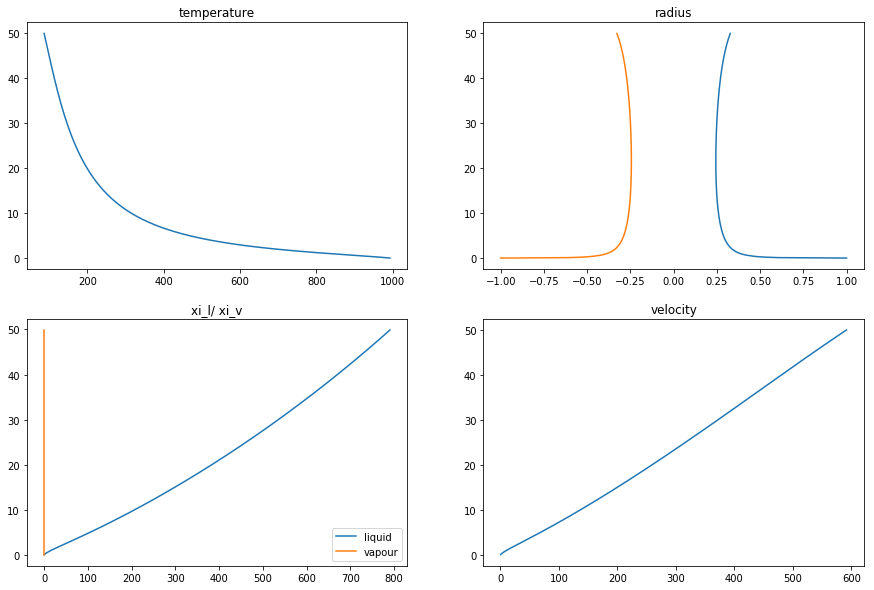

In [327]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

temp = np.array(s.temperature[1:])
axes[0][0].set_title('temperature')
axes[0][0].plot(temp, np.arange(0, s.h, s.step))

radius = s.radius
axes[0][1].set_title('radius')
axes[0][1].plot(radius, np.arange(0, s.h + s.step, s.step))
axes[0][1].plot([-1 * x for x in radius], np.arange(0, s.h + s.step, s.step))

xi_l = np.cumsum(s.xi_l_hist)
xi_v = np.cumsum(s.xi_v_hist)
axes[1][0].plot(xi_l, np.arange(0, s.h, s.step), label='liquid')
axes[1][0].plot(xi_v, np.arange(0, s.h, s.step), label='vapour')
axes[1][0].set_title('xi_l/ xi_v')
axes[1][0].legend()

velocity = np.cumsum(s.velocity)/27
axes[1][1].plot(velocity, np.arange(0, s.h + s.step, s.step))
axes[1][1].set_title('velocity')

plt.show()

# Without boiling/entrainment water

In [199]:
import numpy as np
import scipy as sp
from pathlib2 import Path
import matplotlib.pyplot as plt

class SimpleSolver:
    def __init__(self, step=0.1):
        self.step = step
        self.ro_w = 1000 # kg/m^3
        self.mu_g = 44  # g/mol
        self.g = -9.8
    

        self.c_v = 3 * 8.134 / 2 
        self.c_p = 5 * 8.134 / 2 

        self.v = 0
        self.r = 0
        self.t = 0
        self.ro = 0

        self.velocity = []
        self.radius = []
        self.temperature = []
        self.gas_density = []
    
    def set_initial_conditions(self, t=1, r=0, p=0, q=0, h=0):
        self.h = h
        self.t = t
        self.r = r
        self.ro = (p + self.ro_w * np.abs(self.g) * h) * self.mu_g / (8.3145 * self.t * 10**3)
        self.v = q / (np.pi * self.r ** 2 * self.ro)
        
        print('INITIAL CONDITIONS:')
        print('ro: ', self.ro)
        print('v: ', self.v)
        print('T: ', self.t)
        print('r: ', self.r)
        print('p: ', p)
        
        self.iter_num = int(self.h / self.step)

        self.velocity.append(self.v)
        self.radius.append(self.r)
        self.temperature.append(self.t)
        self.gas_density.append(self.ro)
        

    def do_iteration(self, indx):
        A = np.array([[2 * np.pi * self.r * self.ro * self.v ** 2, 2 * np.pi * self.v * self.ro * self.r ** 2, np.pi * self.r ** 2 * self.v ** 2, 0],
                     [2 * np.pi * self.ro * self.r * self.v, np.pi * self.ro * self.r ** 2, np.pi * self.v * self.r ** 2, 0],
                     [0, 0, 8.3145 * self.t / self.mu_g, 8.3145 * self.ro / self.mu_g],
                     [0, self.v, 0, self.c_p]])
 
        
        r_h_s = [-np.pi * self.r**2 * self.g * (self.ro_w / 10 ** 2 - self.ro), 
             0,
             self.g * self.ro_w / 10** 3, 
             self.g]
        
        #print(r_h_s, '\n')

        return np.linalg.solve(A, r_h_s)

    def make_time_iter(self):
        for indx in range(1, self.iter_num + 1):
            #print("\nIteration #", indx)
            new_iteration = self.do_iteration(indx)
            
            #print(np.array(new_iteration), '\n')
            
            self.r = self.r + new_iteration[0] * self.step
            self.v = self.v + new_iteration[1] * self.step
            self.ro = self.ro + new_iteration[2] * self.step
            self.t = self.t + new_iteration[3] * self.step 
            
            #print('v', self.v)
            #print('r', self.r)
            #print('t', self.t)
            #print('ro_v', self.ro)

            self.velocity.append(self.v)
            self.radius.append(self.r)
            self.temperature.append(self.t)

            self.gas_density.append(self.ro)

INITIAL CONDITIONS:
ro:  3.1292681460099825
v:  10.172023340015018
T:  1000
r:  1
p:  101325


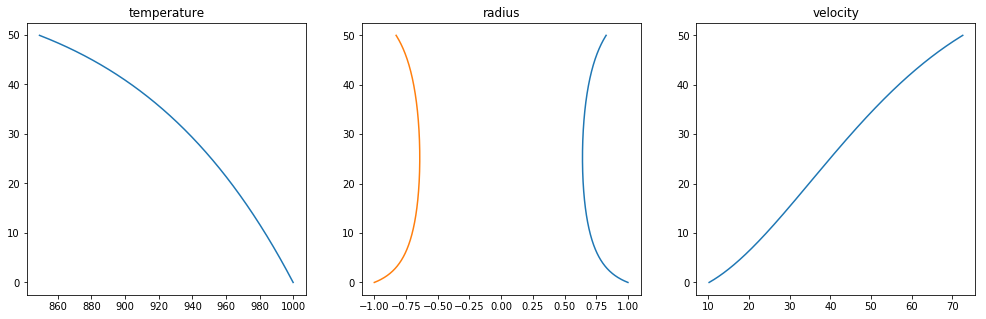

In [200]:
s = SimpleSolver(0.1)
s.set_initial_conditions(t=1000, r=1, p=101325, q=100, h=50)

s.make_time_iter()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(17, 5))

temp = np.array(s.temperature[1:])
axes[0].set_title('temperature')
axes[0].plot(temp, np.arange(0, s.h, s.step))

radius = s.radius
axes[1].set_title('radius')
axes[1].plot(radius, np.arange(0, s.h + s.step, s.step))
axes[1].plot([-1 * x for x in radius], np.arange(0, s.h + s.step, s.step))

velocity = s.velocity
axes[2].plot(velocity, np.arange(0, s.h + s.step, s.step))
axes[2].set_title('velocity')

plt.show()

INITIAL CONDITIONS:
ro:  3.1292681460099825
v:  1.5258035010022528
T:  1000
r:  1
p:  101325


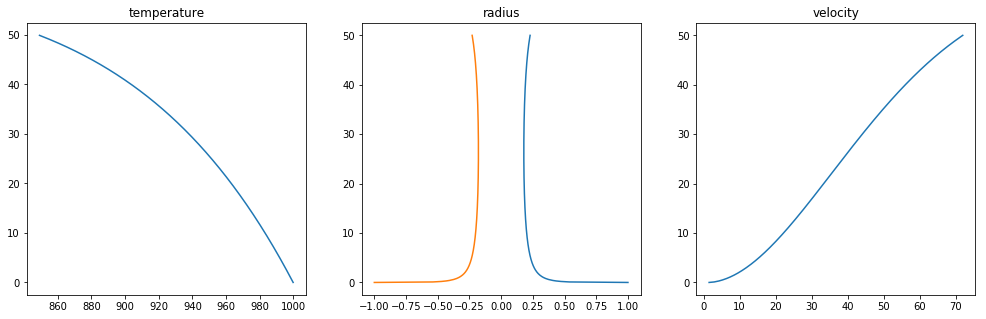

In [201]:
s = SimpleSolver(0.1)
s.set_initial_conditions(t=1000, r=1, p=101325, q=15, h=50)

s.make_time_iter()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(17, 5))

temp = np.array(s.temperature[1:])
axes[0].set_title('temperature')
axes[0].plot(temp, np.arange(0, s.h, s.step))

radius = s.radius
axes[1].set_title('radius')
axes[1].plot(radius, np.arange(0, s.h + s.step, s.step))
axes[1].plot([-1 * x for x in radius], np.arange(0, s.h + s.step, s.step))

velocity = s.velocity
axes[2].plot(velocity, np.arange(0, s.h + s.step, s.step))
axes[2].set_title('velocity')

plt.show()

INITIAL CONDITIONS:
ro:  3.1292681460099825
v:  152.58035010022527
T:  1000
r:  1
p:  101325


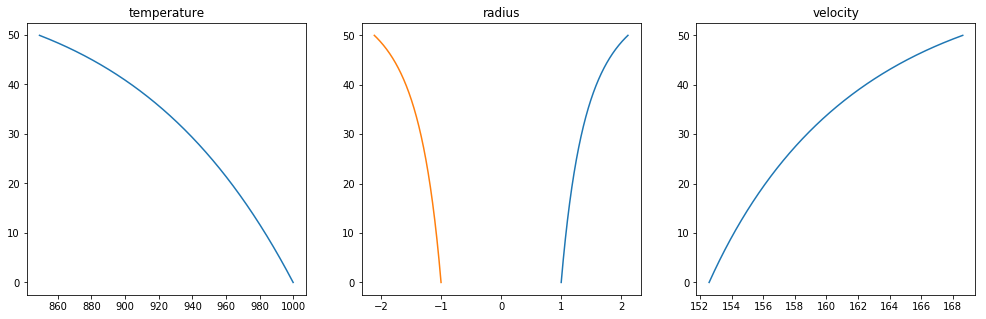

In [202]:
s = SimpleSolver(0.1)
s.set_initial_conditions(t=1000, r=1, p=101325, q=1500, h=50)

s.make_time_iter()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(17, 5))

temp = np.array(s.temperature[1:])
axes[0].set_title('temperature')
axes[0].plot(temp, np.arange(0, s.h, s.step))

radius = s.radius
axes[1].set_title('radius')
axes[1].plot(radius, np.arange(0, s.h + s.step, s.step))
axes[1].plot([-1 * x for x in radius], np.arange(0, s.h + s.step, s.step))

velocity = s.velocity
axes[2].plot(velocity, np.arange(0, s.h + s.step, s.step))
axes[2].set_title('velocity')

plt.show()

# With entrainment water

In [13]:
import numpy as np
import scipy as sp
from pathlib2 import Path
import matplotlib.pyplot as plt

class SimpleSolver:
    def __init__(self, step=0.1):
        self.step = step
        self.ro_w = 1000 # kg/m^3
        self.mu_g = 44  # g/mol
        self.g = -9.8
        
        self.c_pg = (7 / 2) * 8.134 / self.mu_g
        self.c_vg = (5 / 2) * 8.134 / self.mu_g
        self.c_l = 4.183  # heat capasity of the water
        self.c_p = 5 * 8.134 / 2
        self.c_v = 3 * 8.134 / 2
        
        self.eta = 3 * 10 ** -5 # Pa * sec
        
        self.v = 0
        self.r = 0
        self.t = 0
        self.ro_g = 0
        self.ro_l = 0
        self.xi_l = 0
        
        self.velocity = []
        self.radius = []
        self.temperature = []
        self.gas_density = []
        self.liquid_density = []
        self.xi_l_hist = []

    def set_initial_conditions(self, t=1, r=0, p=0, q=0, h=0):
        self.h = h
        self.t = t
        self.r = r
        self.ro_g = (p + self.ro_w * np.abs(self.g) * h) * self.mu_g / (8.3145 * self.t * 10**3)
        self.ro_l = 0
        self.v = q / (np.pi * self.r ** 2 * self.ro_g)
        
        print('INITIAL CONDITIONS:')
        print('ro: ', self.ro_g)
        print('v: ', self.v)
        print('T: ', self.t)
        print('r: ', self.r)
        print('p: ', p)
        
        self.iter_num = int(self.h / self.step)

        self.velocity.append(self.v)
        self.radius.append(self.r)
        self.temperature.append(self.t)
        self.gas_density.append(self.ro_g)
        self.liquid_density.append(self.ro_l)

    def get_ro(self):
        #TODO
        return  (0.4 * self.ro_g + 0.6 * self.ro_l)##(self.c_vg * self.ro_g + self.c_l * self.ro_l) / self.c_v ##

    def do_iteration(self, indx):
        #self.c_pg / self.c_v
        #self.c_l / self.c_p
        self.xi_l = 0.027 * np.pi * self.ro_g  * self.v ** 2 / (10 ** 3 * (self.ro_g * self.v * (indx * self.step) / self.eta) ** (1/7))
        
        A = np.array([[2 * np.pi * self.r * self.get_ro() * self.v ** 2, 2 * np.pi * self.v * self.get_ro() * self.r ** 2, np.pi * self.r ** 2 * self.v ** 2 * 0.4, 0, np.pi * self.r ** 2 * self.v ** 2 * 0.6],
                     [2 * np.pi * self.ro_g * self.r * self.v, np.pi * self.ro_g * self.r ** 2, np.pi * self.v * self.r ** 2, 0, 0],
                     [2 * np.pi * self.ro_l * self.r * self.v, np.pi * self.ro_l * self.r ** 2, 0, 0, np.pi * self.v * self.r ** 2],
                     [0, 0, 8.3145 * self.t / self.mu_g, 8.3145 * self.ro_g / self.mu_g, 0],
                     [0, self.v, 0, self.c_p, 0]])
 
        r_h_s = [-np.pi * self.r**2 * self.g * (self.ro_w / 10 ** 2 - self.get_ro()), 
                 0,
                 self.xi_l,
                 self.g * self.ro_w / 10** 3, 
                 self.g - (self.c_l * self.xi_l * self.t + self.xi_l * (0.5 * self.v ** 2 + np.abs(self.g) * (indx * self.step)))/( np.pi * self.r ** 2 * self.get_ro() * self.v)]
        
        print(r_h_s, '\n')

        return np.linalg.solve(A, r_h_s)

    def make_time_iter(self):
        for indx in range(1, self.iter_num + 1):
            print("\nIteration #", indx)
            new_iteration = self.do_iteration(indx)
            
            print(np.array(new_iteration), '\n')
            
            self.r = self.r + new_iteration[0] * self.step
            self.v = self.v + new_iteration[1] * self.step
            self.ro_g = self.ro_g + new_iteration[2] * self.step
            self.t = self.t + new_iteration[3] * self.step 
            self.ro_l = self.ro_l + new_iteration[4] * self.step
            print('v', self.v)
            print('r', self.r)
            print('t', self.t)
            print('ro_g', self.ro_g)
            print('ro_l', self.ro_l)
            print("Xi_l:", self.xi_l)
            
            self.velocity.append(self.v)
            self.radius.append(self.r)
            self.temperature.append(self.t)
            self.gas_density.append(self.ro_g)
            self.liquid_density.append(self.ro_l)
            
            self.xi_l_hist.append(self.xi_l)

In [14]:
s = SimpleSolver(0.1)
s.set_initial_conditions(t=1000, r=1, p=101325, q=100, h=50)

s.make_time_iter()

INITIAL CONDITIONS:
ro:  3.1292681460099825
v:  10.172023340015018
T:  1000
r:  1
p:  101325

Iteration # 1
[269.3390076428191, 0, 0.0052578700074123, -9.8, -10.356770975327654] 

[-3.24592790e-01  6.73267294e+00 -3.97285902e-02 -3.87714174e+00
  1.64532851e-04] 

v 10.845290634357415
r 0.967540720961373
t 999.612285825933
ro_g 3.125295286992017
ro_l 1.6453285130056586e-05
Xi_l: 0.0052578700074123

Iteration # 2
[252.18320125737137, 0, 0.005358263718636751, -9.8, -10.37006698143852] 

[-2.75926789e-01  6.32371157e+00 -3.97423611e-02 -3.88259439e+00
  1.67785061e-04] 

v 11.477661791518734
r 0.9399480420621401
t 999.2240263872144
ro_g 3.1213210508856752
ro_l 3.323179123618929e-05
Xi_l: 0.005358263718636751

Iteration # 3
[238.0475635656672, 0, 0.0056118098149496734, -9.8, -10.3994163604565] 

[-2.39031928e-01  5.98379724e+00 -3.97537582e-02 -3.88883291e+00
  1.75730528e-04] 

v 12.076041515615856
r 0.9160448492975841
t 998.8351430957399
ro_g 3.1173456750703292
ro_l 5.080484401215502e-05

ro_g 2.717275297681575
ro_l 0.0053704854382925025
Xi_l: 0.030641899319073754

Iteration # 103
[78.04192357222243, 0, 0.030841043186938515, -9.8, -13.667660184587685] 

[-9.04683488e-03  1.97337906e+00 -4.12052797e-02 -4.57346842e+00
  7.76883575e-04] 

v 40.39935580741257
r 0.5324798071806949
t 956.5518956798278
ro_g 2.713154769706683
ro_l 0.0054481737957981806
Xi_l: 0.030841043186938515

Iteration # 104
[77.7913922512225, 0, 0.031039453925242804, -9.8, -13.697982851027461] 

[-8.91573106e-03  1.96670561e+00 -4.12237396e-02 -4.58085185e+00
  7.79768714e-04] 

v 40.59602636800868
r 0.5315882340742147
t 956.0938104947052
ro_g 2.7090323957450697
ro_l 0.005526150667161587
Xi_l: 0.031039453925242804

Iteration # 105
[77.5450448268887, 0, 0.031237135824116517, -9.8, -13.728287823288804] 

[-8.78715222e-03  1.96013783e+00 -4.12422754e-02 -4.58825154e+00
  7.82606454e-04] 

v 40.792040151490546
r 0.5307095188518407
t 955.6349853407808
ro_g 2.7049081682023504
ro_l 0.005604411312591804
Xi_l: 0.0


Iteration # 186
[66.39202132069917, 0, 0.045087791678284424, -9.8, -16.137291207673883] 

[-2.89189398e-03  1.65029129e+00 -4.30084717e-02 -5.25703640e+00
  8.69444624e-04] 

v 55.164134239785156
r 0.4879802647629297
t 915.8316995106644
ro_g 2.363967882915227
ro_l 0.012482236657666013
Xi_l: 0.045087791678284424

Iteration # 187
[66.32562990415306, 0, 0.04523412004469036, -9.8, -16.166513832589054] 

[-2.84863910e-03  1.64826364e+00 -4.30337654e-02 -5.26636589e+00
  8.68884913e-04] 

v 55.32896060367022
r 0.4876954008531571
t 915.3050629211945
ro_g 2.3596645063764363
ro_l 0.012569125148924054
Xi_l: 0.04523412004469036

Iteration # 188
[66.26043909352876, 0, 0.0453798751371338, -9.8, -16.195722868761578] 

[-2.80574904e-03  1.64626622e+00 -4.30591511e-02 -5.27572765e+00
  8.68287908e-04] 

v 55.49358722572262
r 0.4874148259493452
t 914.7774901563688
ro_g 2.3553585912617954
ro_l 0.012655953939738947
Xi_l: 0.0453798751371338

Iteration # 189
[66.1964376120797, 0, 0.045525057411815076, -9.

t 854.6625124613346
ro_g 1.8963354577293776
ro_l 0.020609806581314304
Xi_l: 0.057317892860997366

Iteration # 292
[64.71905306654578, 0, 0.05740306094789923, -9.8, -19.130612853863987] 

[ 6.08307404e-04  1.57041688e+00 -4.62808586e-02 -6.48972277e+00
  6.13482213e-04] 

v 72.00923650758062
r 0.47731356879477
t 854.0135401844752
ro_g 1.8917073718647635
ro_l 0.020671154802606558
Xi_l: 0.05740306094789923

Iteration # 293
[64.74827922777065, 0, 0.057487605009425444, -9.8, -19.157458390892288] 

[ 6.37488998e-04  1.57079726e+00 -4.63184249e-02 -6.50451781e+00
  6.09261802e-04] 

v 72.16631623340885
r 0.4773773176945891
t 853.3630884034671
ro_g 1.8870755293736015
ro_l 0.02073208098284262
Xi_l: 0.057487605009425444

Iteration # 294
[64.77831826373428, 0, 0.05757152362265122, -9.8, -19.1842680953147] 

[ 6.66696785e-04  1.57119814e+00 -4.63561413e-02 -6.51939268e+00
  6.05008893e-04] 

v 72.32343604781603
r 0.4774439873731021
t 852.7111491350838
ro_g 1.882439915241255
ro_l 0.0207925818721758

v 86.23027502757296
r 0.49504543576840376
t 789.9679009418204
ro_g 1.4677484363811846
ro_l 0.02405291110829794
Xi_l: 0.06223496622587121

Iteration # 381
[70.91256220848727, 0, 0.06225620535045805, -9.8, -21.329245531782234] 

[ 3.62489530e-03  1.69502665e+00 -5.03462309e-02 -8.23662944e+00
  1.12685791e-04] 

v 86.39977769239387
r 0.49540792529835587
t 789.1442379981966
ro_g 1.4627138132904502
ro_l 0.02406417968737632
Xi_l: 0.06225620535045805

Iteration # 382
[71.03161543424332, 0, 0.062276587551736595, -9.8, -21.351003461891537] 

[ 3.66823838e-03  1.69767765e+00 -5.04022784e-02 -8.26309196e+00
  1.05633197e-04] 

v 86.56954545730278
r 0.4957747491368118
t 788.3179288025411
ro_g 1.457673585450499
ro_l 0.024074743007043233
Xi_l: 0.062276587551736595

Iteration # 383
[71.15205336049782, 0, 0.062296108495815204, -9.8, -21.37267381595929] 

[ 3.71193097e-03  1.70036369e+00 -5.04586188e-02 -8.28976570e+00
  9.85488802e-05] 

v 86.73958182616258
r 0.49614594223386804
t 787.4889522328338
r

r 0.5760292168966236
t 675.0792926106303
ro_g 0.8657384721625212
ro_l 0.020268386516363642
Xi_l: 0.057900355256600096

Iteration # 492
[98.49440042341391, 0, 0.05777887513345498, -9.8, -22.87629504502893] 

[ 1.34700590e-02  2.35275677e+00 -5.93868010e-02 -1.35957995e+01
 -8.76102156e-04] 

v 108.02129562137529
r 0.5773762227945556
t 673.7197126583093
ro_g 0.8597997920610759
ro_l 0.020180776300743174
Xi_l: 0.05777887513345498

Iteration # 493
[98.98050425690136, 0, 0.057655321232737124, -9.8, -22.877215112670964] 

[ 1.36617928e-02  2.36469212e+00 -5.95107779e-02 -1.36864678e+01
 -8.87167574e-04] 

v 108.25776483380716
r 0.578742402074883
t 672.3510658811898
ro_g 0.8538487142717122
ro_l 0.020092059543298645
Xi_l: 0.057655321232737124

Iteration # 494
[99.47456703670922, 0, 0.0575296678405362, -9.8, -22.87775026025325] 

[ 1.38575648e-02  2.37682877e+00 -5.96360513e-02 -1.37786044e+01
 -8.98281715e-04] 

v 108.49544771124243
r 0.5801281585570583
t 670.973205439762
ro_g 0.847885109140789

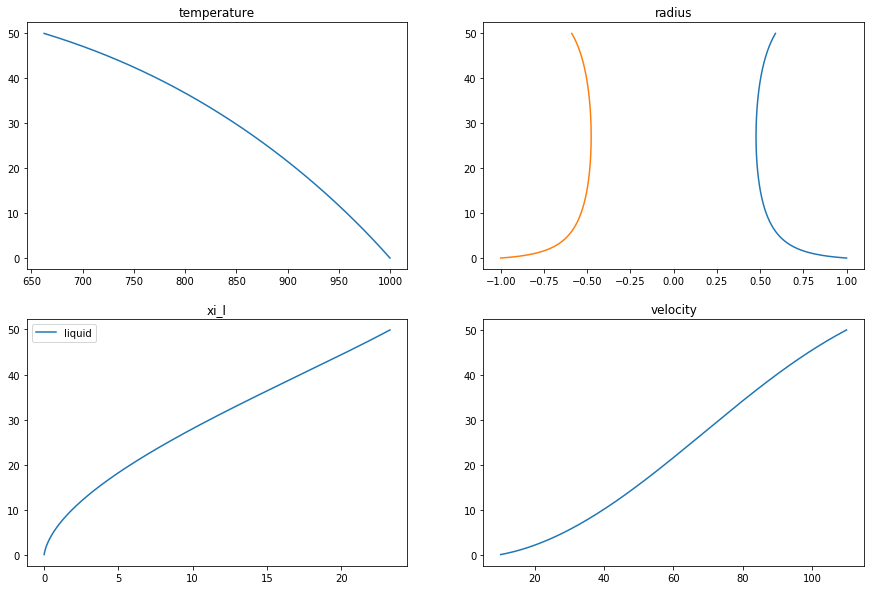

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

temp = np.array(s.temperature[1:])
axes[0][0].set_title('temperature')
axes[0][0].plot(temp, np.arange(0, s.h, s.step))

radius = s.radius
axes[0][1].set_title('radius')
axes[0][1].plot(radius, np.arange(0, s.h + s.step, s.step))
axes[0][1].plot([-1 * x for x in radius], np.arange(0, s.h + s.step, s.step))

xi_l = np.cumsum(s.xi_l_hist)
axes[1][0].plot(xi_l, np.arange(0, s.h, s.step), label='liquid')
axes[1][0].set_title('xi_l')
axes[1][0].legend()

velocity = s.velocity
axes[1][1].plot(velocity, np.arange(0, s.h + s.step, s.step))
axes[1][1].set_title('velocity')

plt.show()

# With boiling water

In [156]:
import numpy as np
import scipy as sp
from pathlib2 import Path
import matplotlib.pyplot as plt

class SimpleSolver:
    def __init__(self, step=0.1):
        self.step = step
        self.ro_w = 1000 # kg/m^3
        self.mu_g = 44  # g/mol
        self.mu_w = 18 # g/mol
        self.g = -9.8
        
        self.c_pg = (7 / 2) * 8.134 / self.mu_g
        self.c_vg = (5 / 2) * 8.134 / self.mu_g
        self.c_pv = (7 / 2) * 8.134 / self.mu_w
        self.c_vv = (5 / 2) * 8.134 / self.mu_w
        self.c_l = 4.183  # heat capasity of the water
        self.c_p = 5 * 8.134 / 2
        self.c_v = 3 * 8.134 / 2
        
        self.eta = 3 * 10 ** -5 # Pa * sec
        self.kappa = 0.02
        self.l = 2260  * 10 ** 3#Dj / kg

        self.v = 0
        self.r = 0
        self.t = 0
        self.ro_g = 0
        self.ro_l = 0
        self.ro_v = 0
        self.xi_l = 0
        self.xi_v = 0
        
        self.velocity = []
        self.radius = []
        self.temperature = []
        self.gas_density = []
        self.liquid_density = []
        self.vapour_densitty = []
        self.xi_l_hist = []
        self.xi_v_hist = []
        
        self.a = 0.3   #g  0.3
        self.b = 0.5   #l  0.4
        self.c = 0.5   #v  0.3

    def set_initial_conditions(self, t=1, r=0, p=0, q=0, h=0):
        self.h = h
        self.t = t
        self.r = r
        self.p = p
        self.ro_g = (p + self.ro_w * np.abs(self.g) * h) * self.mu_g / (8.3145 * self.t * 10**3)
        self.ro_l = 0
        self.ro_v = 0
        self.v = q / (np.pi * self.r ** 2 * self.ro_g)
        
        print('INITIAL CONDITIONS:')
        print('ro: ', self.ro_g)
        print('v: ', self.v)
        print('T: ', self.t)
        print('r: ', self.r)
        print('p: ', p)
        
        self.iter_num = int(self.h / self.step)

        self.velocity.append(self.v)
        self.radius.append(self.r)
        self.temperature.append(self.t)
        self.gas_density.append(self.ro_g)
        self.liquid_density.append(self.ro_l)

    def get_ro(self):
        #TODO
        return  (self.a * self.ro_g + self.b * self.ro_l + self.c * self.ro_v)##(self.c_vg * self.ro_g + self.c_l * self.ro_l) / self.c_v #

    def do_iteration(self, indx):
        
        eta = 0.5 * self.ro_g * self.v ** 2 * 0.027 / (10 ** 3 * (self.ro_g * self.v * (indx * self.step) / self.eta) ** (1/7))
        kappa = 0.023 * (0.01 * self.ro_g * self.r * (indx * self.step) / self.eta) ** (4/5) * self.kappa
        
        if (self.t >= self.get_t_boiling(indx)):
            self.xi_v = 2 * np.pi * (kappa * self.t  - eta * self.v ** 2 /2 ) / self.l
            self.xi_l = 2 * np.pi * eta - self.xi_v 
        else:
            self.xi_l = 0.027 * np.pi * self.ro_g  * self.v ** 2 / (10 ** 3 * (self.ro_g * self.v * (indx * self.step) / self.eta) ** (1/7))
            self.xi_v = 0
        
        A = np.array([[2 * np.pi * self.r * self.get_ro() * self.v ** 2, 2 * np.pi * self.v * self.get_ro() * self.r ** 2, np.pi * self.r ** 2 * self.v ** 2 * self.a, 0, np.pi * self.r ** 2 * self.v ** 2 * self.b, np.pi * self.r ** 2 * self.v ** 2 * self.c],
                     [2 * np.pi * self.ro_g * self.r * self.v, np.pi * self.ro_g * self.r ** 2, np.pi * self.v * self.r ** 2, 0, 0, 0],
                     [2 * np.pi * self.ro_l * self.r * self.v, np.pi * self.ro_l * self.r ** 2, 0, 0, np.pi * self.v * self.r ** 2, 0],
                     [2 * np.pi * self.ro_v * self.r * self.v, np.pi * self.ro_v * self.r ** 2, 0, 0, 0, np.pi * self.v * self.r ** 2],
                     [0, 0, 8.3145 * self.t / self.mu_g, 8.3145 * (self.ro_g / self.mu_g + self.ro_v / self.mu_w), 0, 8.3145 * self.t / self.mu_w],
                     [0, self.v, 0, self.c_p, 0, 0]])
 
        r_h_s = [-np.pi * self.r**2 * self.g * (self.ro_w / (10 ** 2) - self.get_ro()), 
                 0,
                 self.xi_l,
                 self.xi_v,
                 self.g * self.ro_w / 10** 3, 
                 self.g - ((self.l + self.c_pv * self.t) * self.xi_v + self.c_l * self.xi_l * self.t + (self.xi_l + self.xi_v) * (0.5 * self.v ** 2 + np.abs(self.g) * (indx * self.step)))/( np.pi * self.r ** 2 * self.get_ro() * self.v)]
        
        print(r_h_s, '\n')

        return np.linalg.solve(A, r_h_s)

    def get_t_boiling(self, indx):
        return (1/373 - 8.3145 * np.log((self.p + self.ro_w * np.abs(self.g) * (self.h - indx * self.step))/ self.p)/ ( self.mu_w * self.l)) ** (-1)


    def make_time_iter(self):
        for indx in range(1, self.iter_num + 1):
            print("\nIteration #", indx)
            new_iteration = self.do_iteration(indx)
            
            print(np.array(new_iteration), '\n')
            
            self.r = self.r + new_iteration[0] * self.step
            self.v = self.v + new_iteration[1] * self.step
            self.ro_g = self.ro_g + new_iteration[2] * self.step
            self.t = self.t + new_iteration[3] * self.step 
            self.ro_l = self.ro_l + new_iteration[4] * self.step
            
            self.ro_v = self.ro_v + new_iteration[5] * self.step
            print('v', self.v)
            print('r', self.r)
            print('t', self.t)
            print('ro_g', self.ro_g)
            print('ro_l', self.ro_l)
            print('ro_v', self.ro_v)
            print("Xi_l:", self.xi_l)
            print("Xi_v:", self.xi_v)
            
            self.velocity.append(self.v)
            self.radius.append(self.r)
            self.temperature.append(self.t)
            self.gas_density.append(self.ro_g)
            self.liquid_density.append(self.ro_l)
            self.vapour_densitty.append(self.ro_v)
            self.xi_l_hist.append(self.xi_l)
            self.xi_v_hist.append(self.xi_v)


In [157]:
s = SimpleSolver(0.1)
s.set_initial_conditions(t=1000, r=1, p=101325, q=100, h=50)

s.make_time_iter()

INITIAL CONDITIONS:
ro:  3.1292681460099825
v:  10.172023340015018
T:  1000
r:  1
p:  101325

Iteration # 1
[278.9732757450643, 0, 0.0052053296863463746, 5.254032106592709e-05, -9.8, -14.495842893822061] 

[-4.51443485e-01  9.29821781e+00 -3.50797400e-02 -5.36402908e+00
  1.62888724e-04  1.64412753e-06] 

v 11.101845120537842
r 0.9548556515106703
t 999.4635970915705
ro_g 3.1257601720142874
ro_l 1.6288872376963847e-05
ro_v 1.6441275309274292e-07
Xi_l: 0.0052053296863463746
Xi_v: 5.254032106592709e-05

Iteration # 2
[254.3830034590791, 0, 0.005508680024532595, 8.808178765584539e-05, -9.8, -17.264577382796503] 

[-3.61517899e-01  8.52970178e+00 -3.46768246e-02 -5.50577848e+00
  1.73050872e-04  2.76808589e-06] 

v 11.954815298501366
r 0.9187038615942487
t 998.9130192432071
ro_g 3.1222924895577213
ro_l 3.3593959590597577e-05
ro_v 4.4122134224690997e-07
Xi_l: 0.005508680024532595
Xi_v: 8.808178765584539e-05

Iteration # 3
[235.5120644444203, 0, 0.005936422918384813, 0.00011797013178237326, -

ro_l 0.0023457929955844467
ro_v 6.871837437464634e-05
Xi_l: 0.02442187135075583
Xi_v: 0.0006997022375228304

Iteration # 51
[88.11940911231449, 0, 0.024757832572846104, 0.0007072230078258368, -9.8, -68.76293516271116] 

[-2.29963434e-02  3.01625636e+00 -2.83117904e-02 -8.26825609e+00
  7.38721345e-04  2.10857726e-05] 

v 33.247118568758104
r 0.5583333045599
t 963.7757017771667
ro_g 2.972392503467399
ro_l 0.0024196651300725917
ro_v 7.082695163552477e-05
Xi_l: 0.024757832572846104
Xi_v: 0.0007072230078258368

Iteration # 52
[87.40577302358464, 0, 0.025092265534201946, 0.0007146480416350317, -9.8, -69.40145264556872] 

[-2.24648538e-02  2.99143011e+00 -2.82510978e-02 -8.30380547e+00
  7.47637639e-04  2.12751439e-05] 

v 33.54626157966648
r 0.556086819176421
t 962.9453212304618
ro_g 2.9695673936906655
ro_l 0.002494428893926269
ro_v 7.295446602904751e-05
Xi_l: 0.025092265534201946
Xi_v: 0.0007146480416350317

Iteration # 53
[86.71152691066956, 0, 0.025425197459622444, 0.0007219794500080124,

Xi_l: 0.03830413013225241
Xi_v: 0.0009640691645030971

Iteration # 96
[67.8928313880689, 0, 0.03858869510190052, 0.0009685716613253759, -9.8, -91.66859272313842] 

[-1.03525973e-02  2.30224633e+00 -2.66389297e-02 -9.56959828e+00
  1.07850957e-03  2.69201513e-05] 

v 44.93838073776221
r 0.4901291549440459
t 923.3718830683133
ro_g 2.849569751169203
ro_l 0.006569391694991669
ro_v 0.00018096971796273728
Xi_l: 0.03858869510190052
Xi_v: 0.0009685716613253759

Iteration # 97
[67.61243044846066, 0, 0.038872372492895636, 0.0009730254958781834, -9.8, -92.06912201976577] 

[-1.02102110e-02  2.29211916e+00 -2.66220356e-02 -9.59297986e+00
  1.08480524e-03  2.69996454e-05] 

v 45.167592653594255
r 0.48910813384428464
t 922.4125850823153
ro_g 2.8469075476044505
ro_l 0.006677872218766072
ro_v 0.00018366968249775896
Xi_l: 0.038872372492895636
Xi_v: 0.0009730254958781834

Iteration # 98
[67.33650071043027, 0, 0.03915516907195224, 0.0009774311612562026, -9.8, -92.46578860591457] 

[-1.00708814e-02  2.282

ro_g 2.7303832648438178
ro_l 0.012002099468062015
ro_v 0.0003078557862798968
Xi_l: 0.050555251121406915
Xi_v: 0.0011268558486406996

Iteration # 142
[58.4314018383672, 0, 0.05080396732349875, 0.0011295036385985798, -9.8, -106.56695452436288] 

[-5.94631563e-03  1.95305475e+00 -2.65692346e-02 -1.04686719e+01
  1.31934799e-03  2.89333744e-05] 

v 54.62976982588282
r 0.45422429768200023
t 877.1097855667524
ro_g 2.7277263413831507
ro_l 0.01213403426684547
ro_v 0.0003107491237229514
Xi_l: 0.05080396732349875
Xi_v: 0.0011295036385985798

Iteration # 143
[58.28334983831897, 0, 0.05105198057094228, 0.0011321176412047219, -9.8, -106.81981957517685] 

[-5.88271480e-03  1.94741865e+00 -2.65825815e-02 -1.04847235e+01
  1.32350874e-03  2.89437801e-05] 

v 54.82451169071914
r 0.4536360262017368
t 876.0613132181421
ro_g 2.725068083228378
ro_l 0.012266385140872933
ro_v 0.0003136435017296869
Xi_l: 0.05105198057094228
Xi_v: 0.0011321176412047219

Iteration # 144
[58.13710473305689, 0, 0.0512992928671991

Xi_v: 0.0012151231516087857

Iteration # 187
[53.23782183441814, 0, 0.061290460472064774, 0.0012164212037893778, -9.8, -115.47834079464656] 

[-3.73691872e-03  1.74921430e+00 -2.77396930e-02 -1.10757019e+01
  1.46139239e-03  2.82126121e-05] 

v 62.91512275652246
r 0.4329762011900403
t 828.520912893888
ro_g 2.6059041017173183
ro_l 0.01843273682579722
ro_v 0.00044017567100038406
Xi_l: 0.061290460472064774
Xi_v: 0.0012164212037893778

Iteration # 188
[53.15041725238958, 0, 0.06150814059096018, 0.0012176925336206462, -9.8, -115.6233244020319] 

[-3.69890876e-03  1.74563396e+00 -2.77786469e-02 -1.10868010e+01
  1.46347674e-03  2.81705846e-05] 

v 63.089686152590325
r 0.43260631031445146
t 827.4122327890142
ro_g 2.603126237025805
ro_l 0.018579084499594153
ro_v 0.00044299272945621263
Xi_l: 0.06150814059096018
Xi_v: 0.0012176925336206462

Iteration # 189
[53.06401536665838, 0, 0.06172515980875806, 0.0012189372582354218, -9.8, -115.7661701121557] 

[-3.66124104e-03  1.74208763e+00 -2.78181559e-

r 0.4196679721026406
t 777.6596668751259
ro_g 2.4762009127612012
ro_l 0.025149602231516077
ro_v 0.0005612020053554073
Xi_l: 0.07042690323748052
Xi_v: 0.001248771362145064

Iteration # 233
[50.125751359460466, 0, 0.07061439059561829, 0.0012489449872683345, -9.8, -120.06192705090764] 

[-2.25919300e-03  1.61536900e+00 -3.01070657e-02 -1.15016123e+01
  1.50544022e-03  2.52113935e-05] 

v 70.62429786948991
r 0.41944205280220054
t 776.5095056427381
ro_g 2.4731902061939053
ro_l 0.025300146253609643
ro_v 0.0005637231447048941
Xi_l: 0.07061439059561829
Xi_v: 0.0012489449872683345

Iteration # 234
[50.07627534854353, 0, 0.07080118650087514, 0.0012490962171311903, -9.8, -120.11691561824341] 

[-2.23159020e-03  1.61307762e+00 -3.01717049e-02 -1.15091906e+01
  1.50516394e-03  2.51227043e-05] 

v 70.78560563151397
r 0.41921889378200966
t 775.3585865871357
ro_g 2.470173035700677
ro_l 0.025450662647592773
ro_v 0.0005662354151332372
Xi_l: 0.07080118650087514
Xi_v: 0.0012490962171311903

Iteration # 23

Xi_l: 0.07815647464728091
Xi_v: 0.0012353840136198843

Iteration # 278
[48.53718791603349, 0, 0.07831115113206945, 0.001234615488321879, -9.8, -120.83817839394854] 

[-1.11042241e-03  1.53405980e+00 -3.35922642e-02 -1.17917016e+01
  1.43516804e-03  2.02805465e-05] 

v 77.69019597369619
r 0.41197560076464607
t 724.0496667112715
ro_g 2.330139992958938
ro_l 0.03195856071889944
ro_v 0.0006665475213012919
Xi_l: 0.07831115113206945
Xi_v: 0.001234615488321879

Iteration # 279
[48.51591917391596, 0, 0.0784650496091432, 0.0012338273689084223, -9.8, -120.81767090794985] 

[-1.08622129e-03  1.53273398e+00 -3.36834882e-02 -1.17972006e+01
  1.43218320e-03  2.01495228e-05] 

v 77.84346937144534
r 0.4118669786355979
t 722.8699466522854
ro_g 2.3267716441369823
ro_l 0.03210177903939243
ro_v 0.0006685624735763199
Xi_l: 0.0784650496091432
Xi_v: 0.0012338273689084223

Iteration # 280
[48.49523723011745, 0, 0.07861816750875618, 0.0012330197062987065, -9.8, -120.79559104723106] 

[-1.06204297e-03  1.5314283

v 84.48680949575053
r 0.40948232500610937
t 670.4506817399308
ro_g 2.1685654381692525
ro_l 0.038003584235207236
ro_v 0.0007428675533292521
Xi_l: 0.0844222490020774
Xi_v: 0.001180457960202019

Iteration # 324
[48.16489002854327, 0, 0.08453799572333537, 0.0011788346539432521, -9.8, -118.32101420021625] 

[ 1.03314597e-05  1.49396892e+00 -3.84558798e-02 -1.20256544e+01
  1.22558552e-03  1.33141589e-05] 

v 84.63620638736762
r 0.40948335815208253
t 669.2481163039174
ro_g 2.1647198501870544
ro_l 0.03812614278766016
ro_v 0.0007441989692164289
Xi_l: 0.08453799572333537
Xi_v: 0.0011788346539432521

Iteration # 325
[48.17076898689682, 0, 0.08465281246096884, 0.0011771936839321366, -9.8, -118.23168168763365] 

[ 3.56121342e-05  1.49358032e+00 -3.85774685e-02 -1.20306198e+01
  1.21928235e-03  1.31416087e-05] 

v 84.78556441943806
r 0.4094869193655004
t 668.0450543222755
ro_g 2.1608621033345212
ro_l 0.0382480710228196
ro_v 0.0007455131300888457
Xi_l: 0.08465281246096884
Xi_v: 0.0011771936839321366

ro_l 0.04277715044935605
ro_v 0.0007844426431272176
Xi_l: 0.08864437495819684
Xi_v: 0.0010903399470278182

Iteration # 369
[49.07933246744474, 0, 0.08871349377345353, 0.00108794956570571, -9.8, -112.91145336412882] 

[ 1.25663373e-03  1.49901037e+00 -4.46712460e-02 -1.22756564e+01
  8.58599783e-04  4.67442961e-06] 

v 91.35275223766995
r 0.41229827250231404
t 614.5848736549357
ro_g 1.9779600625568545
ro_l 0.04286301042766839
ro_v 0.0007849100860886155
Xi_l: 0.08871349377345353
Xi_v: 0.00108794956570571

Iteration # 370
[49.11605150515422, 0, 0.08878144730734655, 0.0010855426593245083, -9.8, -112.7594362220214] 

[ 1.28784517e-03  1.49969099e+00 -4.48277684e-02 -1.22822884e+01
  8.48385149e-04  4.46222751e-06] 

v 91.50272133628124
r 0.4124270570189478
t 613.3566448115156
ro_g 1.9734772857187575
ro_l 0.04294784894260543
ro_v 0.000785356308839468
Xi_l: 0.08878144730734655
Xi_v: 0.0010855426593245083

Iteration # 371
[49.15355922448105, 0, 0.08884822900902462, 0.0010831192447304156, -9.8,

[51.620727645309856, 0, 0.09050561095554797, 0.0009634686004108945, -9.8, -104.71280088285769] 

[ 2.93104371e-03  1.56040558e+00 -5.26353579e-02 -1.26738863e+01
  2.98597902e-04 -5.73964646e-06] 

v 98.21431405201426
r 0.4215685448923349
t 558.5175714565282
ro_g 1.7593574505007514
ro_l 0.04551796811444666
ro_v 0.0007826561079388282
Xi_l: 0.09050561095554797
Xi_v: 0.0009634686004108945

Iteration # 415
[51.70114319143903, 0, 0.09051311923749049, 0.0009603292565035772, -9.8, -104.49876988660542] 

[ 2.97652750e-03  1.56259674e+00 -5.28357462e-02 -1.26859177e+01
  2.83670224e-04 -5.99121858e-06] 

v 98.3705737262556
r 0.42186619764205086
t 557.2489796833163
ro_g 1.7540738758790289
ro_l 0.04554633513685735
ro_v 0.0007820569860812369
Xi_l: 0.09051311923749049
Xi_v: 0.0009603292565035772

Iteration # 416
[51.782786218560105, 0, 0.09051907182787211, 0.0009571737245837, -9.8, -104.28332958114781] 

[ 3.02248457e-03  1.56483020e+00 -5.30372612e-02 -1.26981349e+01
  2.68627191e-04 -6.24367342e-

ro_g 1.499888140992469
ro_l 0.04513253624209902
ro_v 0.0007294289172073786
Xi_l: 0.08912234131408814
Xi_v: 0.0008060284888394957

Iteration # 460
[56.88138774990984, 0, 0.08904648017293451, 0.0008021481447531004, -9.8, -93.35535333985945] 

[ 5.69651373e-03  1.71481504e+00 -6.31752947e-02 -1.34906316e+01
 -5.16051230e-04 -1.82478157e-05] 

v 105.70860054779375
r 0.44093860874732854
t 498.53646949908216
ro_g 1.4935706115274303
ro_l 0.045080931119077315
ro_v 0.000727604135639227
Xi_l: 0.08904648017293451
Xi_v: 0.0008021481447531004

Iteration # 461
[57.0401487139432, 0, 0.08896838212537168, 0.0007982507978980669, -9.8, -93.0723976720607] 

[ 5.77773891e-03  1.71969091e+00 -6.34390639e-02 -1.35165241e+01
 -5.36897157e-04 -1.85418435e-05] 

v 105.8805696390716
r 0.4415163826382104
t 497.18481708975526
ro_g 1.4872267051414088
ro_l 0.04502724140333892
ro_v 0.0007257499512898472
Xi_l: 0.08896838212537168
Xi_v: 0.0007982507978980669

Iteration # 462
[57.20131799675436, 0, 0.0888880262252184, 0

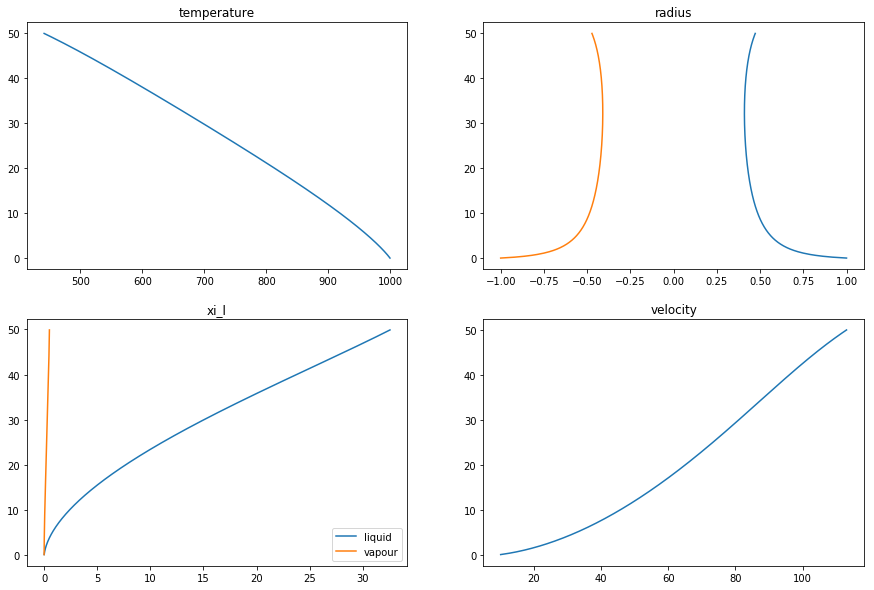

In [158]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

temp = np.array(s.temperature[1:])
axes[0][0].set_title('temperature')
axes[0][0].plot(temp, np.arange(0, s.h, s.step))

radius = s.radius
axes[0][1].set_title('radius')
axes[0][1].plot(radius, np.arange(0, s.h + s.step, s.step))
axes[0][1].plot([-1 * x for x in radius], np.arange(0, s.h + s.step, s.step))

xi_l = np.cumsum(s.xi_l_hist)
xi_v = np.cumsum(s.xi_v_hist)
axes[1][0].plot(xi_l, np.arange(0, s.h, s.step), label='liquid')
axes[1][0].plot(xi_v, np.arange(0, s.h, s.step), label='vapour')
axes[1][0].set_title('xi_l')
axes[1][0].legend()

velocity = s.velocity
axes[1][1].plot(velocity, np.arange(0, s.h + s.step, s.step))
axes[1][1].set_title('velocity')

plt.show()

In [161]:
s = SimpleSolver(0.1)
s.set_initial_conditions(t=1000, r=10, p=101325, q=90000, h=100)

s.make_time_iter()

INITIAL CONDITIONS:
ro:  5.722328462324854
v:  50.063343873312306
T:  1000
r:  10
p:  101325

Iteration # 1
[25502.303837931722, 0, 0.16971076117285155, 0.00044415508076886534, -9.8, -9.871399730711522] 

[-6.30549598e-02  9.44372021e-01 -3.57791486e-02 -2.81041657e+00
  1.07904524e-05  2.82400140e-08] 

v 50.15778107544523
r 9.993694504016672
t 999.7189583428628
ro_g 5.718750547462845
ro_l 1.0790452433580271e-06
ro_v 2.8240014004109696e-09
Xi_l: 0.16971076117285155
Xi_v: 0.00044415508076886534

Iteration # 2
[25473.45187628535, 0, 0.15372042218066467, 0.0008503551558839933, -9.8, -9.902248980106084] 

[-6.27122295e-02  9.43319546e-01 -3.57804122e-02 -2.81372335e+00
  9.76092467e-06  5.40154482e-08] 

v 50.25211303007987
r 9.987423281067345
t 999.4375860081201
ro_g 5.715172506246811
ro_l 2.0551377101909956e-06
ro_v 8.225546222886008e-09
Xi_l: 0.15372042218066467
Xi_v: 0.0008503551558839933

Iteration # 3
[25444.786774644126, 0, 0.14509147231556288, 0.0012117761003777362, -9.8, -9.93082

Xi_v: 0.010989848917729236

Iteration # 48
[24328.53207717076, 0, 0.10013572989948469, 0.011163810259303393, -9.8, -10.756778009897847] 

[-4.90619195e-02  9.01023583e-01 -3.60259703e-02 -2.93926333e+00
  5.96513622e-06  6.77060915e-07] 

v 54.487282226763185
r 9.7325696921531
t 986.1915881211185
ro_g 5.550077394074655
ro_l 3.367893176166799e-05
ro_v 1.9018923397765054e-06
Xi_l: 0.10013572989948469
Xi_v: 0.011163810259303393

Iteration # 49
[24307.173466563276, 0, 0.09991533014953272, 0.011336559320663485, -9.8, -10.77123370394185] 

[-4.88067982e-02  9.00233782e-01 -3.60329088e-02 -2.94185030e+00
  5.94349256e-06  6.86819746e-07] 

v 54.57730560496826
r 9.727689012332123
t 985.8974030910884
ro_g 5.546474103199039
ro_l 3.427328101717245e-05
ro_v 1.970574314382209e-06
Xi_l: 0.09991533014953272
Xi_v: 0.011336559320663485

Iteration # 50
[24285.94885033039, 0, 0.09970184216259459, 0.011508119399333152, -9.8, -10.785591223121017] 

[-4.85531875e-02  8.99448929e-01 -3.60398930e-02 -2.944435

r 9.536120466104476
t 972.6989985746249
ro_g 5.387179148680707
ro_l 5.875973485812177e-05
ro_v 5.835067165457413e-06
Xi_l: 0.0945704057094742
Xi_v: 0.01798670986834822

Iteration # 94
[23472.591369923433, 0, 0.09451111269585567, 0.018120189295588635, -9.8, -11.339753895809007] 

[-3.86925340e-02  8.69367506e-01 -3.63870917e-02 -3.05725136e+00
  5.26130391e-06  1.04540692e-06] 

v 58.55410067785103
r 9.532251212700611
t 972.3932734388169
ro_g 5.383540439514188
ro_l 5.928586524913202e-05
ro_v 5.9396078576805875e-06
Xi_l: 0.09451111269585567
Xi_v: 0.018120189295588635

Iteration # 95
[23456.600243697743, 0, 0.09445361390825971, 0.018253009860090628, -9.8, -11.350899639855982] 

[-3.84939954e-02  8.68776007e-01 -3.63958042e-02 -3.05981300e+00
  5.25013031e-06  1.05187932e-06] 

v 58.640978278525374
r 9.528401813157902
t 972.08729213857
ro_g 5.379900859098754
ro_l 5.981087828015668e-05
ro_v 6.044795789742809e-06
Xi_l: 0.09445361390825971
Xi_v: 0.018253009860090628

Iteration # 96
[23440.710

ro_v 1.1106978709238048e-05
Xi_l: 0.09326724917903964
Xi_v: 0.023412328550939217

Iteration # 139
[22845.963703440386, 0, 0.0932625421957679, 0.02352083348790235, -9.8, -11.79335630030141] 

[-3.06188294e-02  8.46187185e-01 -3.68113732e-02 -3.17347599e+00
  4.83899594e-06  1.28690361e-06] 

v 62.41040054436458
r 9.377323648816107
t 958.3692058859292
ro_g 5.218846945410559
ro_l 8.193749649813499e-05
ro_v 1.1235669070061248e-05
Xi_l: 0.0932625421957679
Xi_v: 0.02352083348790235

Iteration # 140
[22834.040618710424, 0, 0.09325863844628662, 0.023628867600434957, -9.8, -11.802438725495502] 

[-3.04569563e-02  8.45746090e-01 -3.68215256e-02 -3.17609004e+00
  4.83098337e-06  1.29122437e-06] 

v 62.49497515337693
r 9.37427795319074
t 958.051596881902
ro_g 5.2151647928539875
ro_l 8.242059483536087e-05
ro_v 1.1364791506715235e-05
Xi_l: 0.09325863844628662
Xi_v: 0.023628867600434957

Iteration # 141
[22822.198141402216, 0, 0.0932555260951388, 0.02373643371998989, -9.8, -11.811482156380224] 

[-3.

  4.51112247e-06  1.44337523e-06] 

v 66.17691023691498
r 9.25537110136786
t 943.8150195417269
ro_g 5.052098925740793
ro_l 0.00010293707027211902
ro_v 1.7414697011178822e-05
Xi_l: 0.09373524148609894
Xi_v: 0.027953763661919963

Iteration # 185
[22375.88173263926, 0, 0.0937581237421322, 0.028043052736541983, -9.8, -12.173860990986043] 

[-2.37814447e-02  8.28795820e-01 -3.73097128e-02 -3.29584498e+00
  4.50440439e-06  1.44603251e-06] 

v 66.25978981895793
r 9.252992956899517
t 943.4854350440417
ro_g 5.048367954461989
ro_l 0.00010338751071138253
ro_v 1.7559300261964404e-05
Xi_l: 0.0937581237421322
Xi_v: 0.028043052736541983

Iteration # 186
[22367.33399008513, 0, 0.09378144493087201, 0.028131970073456088, -9.8, -12.181349778344316] 

[-2.36449519e-02  8.28479576e-01 -3.73212518e-02 -3.29856072e+00
  4.49770385e-06  1.44865664e-06] 

v 66.34263777653294
r 9.250628461712108
t 943.1555789715713
ro_g 5.0446358292791045
ro_l 0.00010383728109660262
ro_v 1.7704165925644974e-05
Xi_l: 0.093781444

ro_l 0.00012256295335849105
ro_v 2.413675176931027e-05
Xi_l: 0.09513648856316548
Xi_v: 0.031624425255447036

Iteration # 230
[22054.29007496588, 0, 0.09517494042347154, 0.03169837713965849, -9.8, -12.481998505226475] 

[-1.80345477e-02  8.16897964e-01 -3.78586793e-02 -3.42098151e+00
  4.21529913e-06  1.53326927e-06] 

v 69.96025840738653
r 9.159479172545709
t 928.3686681427381
ro_g 4.879234458133976
ro_l 0.00012298448327166005
ro_v 2.4290078696782207e-05
Xi_l: 0.09517494042347154
Xi_v: 0.03169837713965849

Iteration # 231
[22048.540764688012, 0, 0.09521365881598115, 0.03177201613190505, -9.8, -12.488212740712843] 

[-1.79149064e-02  8.16685270e-01 -3.78715732e-02 -3.42383699e+00
  4.20906626e-06  1.53453171e-06] 

v 70.04192693438878
r 9.157687681901415
t 928.0262844433578
ro_g 4.875447300813449
ro_l 0.00012340538989741306
ro_v 2.4443531867647248e-05
Xi_l: 0.09521365881598115
Xi_v: 0.03177201613190505

Iteration # 232
[22042.84944946703, 0, 0.09525264092706223, 0.03184534327675149, -9.

[21851.004344855042, 0, 0.09714301190914865, 0.034716857378457915, -9.8, -12.736997663555014] 

[-1.29153968e-02  8.09378566e-01 -3.84695032e-02 -3.55327665e+00
  3.93657335e-06  1.56392982e-06] 

v 73.6174577625379
r 9.09028727005846
t 912.6729942697699
ro_g 4.707489136195634
ro_l 0.00014131189499075452
ro_v 3.127988244073581e-05
Xi_l: 0.09714301190914865
Xi_v: 0.034716857378457915

Iteration # 276
[21847.73191437595, 0, 0.09719122358223148, 0.034777373332491666, -9.8, -12.742116682171105] 

[-1.28069590e-02  8.09257558e-01 -3.84837995e-02 -3.55631182e+00
  3.93036065e-06  1.56403287e-06] 

v 73.69838351837565
r 9.089006574159614
t 912.3173630880386
ro_g 4.703640756249802
ro_l 0.00014170493105586073
ro_v 3.1436285728231374e-05
Xi_l: 0.09719122358223148
Xi_v: 0.034777373332491666

Iteration # 277
[21844.511913180195, 0, 0.09723959877249741, 0.034837616336880574, -9.8, -12.747212917057425] 

[-1.26987173e-02  8.09138491e-01 -3.84981278e-02 -3.55935145e+00
  3.92414469e-06  1.56411202e-0

t 896.3619642539996
ro_g 4.532847352773633
ro_l 0.000158376366074326
ro_v 3.8293070638840223e-05
Xi_l: 0.09945126566370774
Xi_v: 0.03717920986264145

Iteration # 321
[21753.508016828295, 0, 0.09950526533043128, 0.03722807778653797, -9.8, -12.949722980779272] 

[-8.09980925e-03  8.05775994e-01 -3.91609866e-02 -3.69785814e+00
  3.64544898e-06  1.54496434e-06] 

v 77.33061093861977
r 9.042316661777793
t 895.9921784395385
ro_g 4.528931254113989
ro_l 0.00015874091097238578
ro_v 3.844756707234058e-05
Xi_l: 0.09950526533043128
Xi_v: 0.03722807778653797

Iteration # 322
[21752.568073262137, 0, 0.09955936097198471, 0.03727670004678245, -9.8, -12.95384905810416] 

[-7.99835236e-03  8.05741359e-01 -3.91768064e-02 -3.70112223e+00
  3.63895563e-06  1.54403702e-06] 

v 77.41118507448046
r 9.041516826541681
t 895.6220662163879
ro_g 4.525013573476397
ro_l 0.00015910480653513946
ro_v 3.8601970774618785e-05
Xi_l: 0.09955936097198471
Xi_v: 0.03727670004678245

Iteration # 323
[21751.677430837055, 0, 0.09

Xi_v: 0.03914177178992072

Iteration # 366
[21759.554706696963, 0, 0.10201640234710091, 0.03918004094996861, -9.8, -13.115685887579154] 

[-3.61742153e-03  8.06008164e-01 -3.99079117e-02 -3.85058922e+00
  3.34316466e-06  1.48326224e-06] 

v 80.9557692610475
r 9.016231713538241
t 879.005163399967
ro_g 4.351016127054481
ro_l 0.00017445842347469008
ro_v 4.5273019958043985e-05
Xi_l: 0.10201640234710091
Xi_v: 0.03918004094996861

Iteration # 367
[21760.804613496308, 0, 0.10207360211994501, 0.03921808410712647, -9.8, -13.118928503502126] 

[-3.51917628e-03  8.06054650e-01 -3.99253488e-02 -3.85412848e+00
  3.33618099e-06  1.48144472e-06] 

v 81.03637472600025
r 9.015879795910479
t 878.6197505515655
ro_g 4.3470235921728735
ro_l 0.00017479204157350083
ro_v 4.542116442975406e-05
Xi_l: 0.10207360211994501
Xi_v: 0.03921808410712647

Iteration # 368
[21762.102847732654, 0, 0.10213084595247407, 0.03925590163092845, -9.8, -13.122152273713516] 

[-3.42096505e-03  8.06102926e-01 -3.99428236e-02 -3.8576

r 9.010095667266906
t 861.30042566387
ro_g 4.169567150788164
ro_l 0.00018875886530721339
ro_v 5.173200113191862e-05
Xi_l: 0.10462023223065121
Xi_v: 0.04067344688972023

Iteration # 412
[21867.223631867146, 0, 0.10467846503832087, 0.04070166545850665, -9.8, -13.245770607454114] 

[ 8.90450461e-04  8.10005719e-01 -4.07503689e-02 -4.02087191e+00
  3.00728514e-06  1.38102100e-06] 

v 84.67134104285843
r 9.010184712312979
t 860.8983384733203
ro_g 4.165492113901445
ro_l 0.00018905959382102726
ro_v 5.187010323170289e-05
Xi_l: 0.10467846503832087
Xi_v: 0.04070166545850665

Iteration # 413
[21870.710902163577, 0, 0.10473669972204003, 0.04072967256492711, -9.8, -13.248174832133962] 

[ 9.88751888e-04  8.10135118e-01 -4.07696335e-02 -4.02475543e+00
  2.99962319e-06  1.37839031e-06] 

v 84.75235455463927
r 9.010283587501801
t 860.4958629302523
ro_g 4.161415150554287
ro_l 0.00018935955614030452
ro_v 5.200794226296732e-05
Xi_l: 0.10473669972204003
Xi_v: 0.04072967256492711

Iteration # 414
[21874.24

Xi_l: 0.10723029848629609
Xi_v: 0.041737418756189186

Iteration # 457
[22073.717985534353, 0, 0.10728776441414734, 0.04175635773232956, -9.8, -13.336777364885979] 

[ 5.37432914e-03  8.17666086e-01 -4.16605579e-02 -4.20439941e+00
  2.64511853e-06  1.24659655e-06] 

v 88.33256477358407
r 9.024449624695595
t 842.3892450563841
ro_g 3.980055853413548
ro_l 0.0002017731016572722
ro_v 5.778762861695915e-05
Xi_l: 0.10728776441414734
Xi_v: 0.04175635773232956

Iteration # 458
[22079.48058969126, 0, 0.10734519388319276, 0.041775095373273466, -9.8, -13.338406924365891] 

[ 5.47593520e-03  8.17879836e-01 -4.16818323e-02 -4.20869587e+00
  2.63664245e-06  1.24324863e-06] 

v 88.41435275713671
r 9.024997218215633
t 841.9683754695977
ro_g 3.9758876701825256
ro_l 0.0002020367659021243
ro_v 5.791195348002468e-05
Xi_l: 0.10734519388319276
Xi_v: 0.041775095373273466

Iteration # 459
[22085.295427309637, 0, 0.1074025860597692, 0.0417936318648358, -9.8, -13.340019669431225] 

[ 5.57765289e-03  8.18095522e-0


v 92.03718518677323
r 9.059348770445354
t 823.0085173111582
ro_g 3.7903067464983344
ro_l 0.0002127678750152137
ro_v 6.302829354048424e-05
Xi_l: 0.10982335253435788
Xi_v: 0.04240279833951949

Iteration # 503
[22394.39790013955, 0, 0.10987827857384835, 0.042412644951988425, -9.8, -13.394543985992243] 

[ 1.01909401e-02  8.29560416e-01 -4.26907379e-02 -4.41332430e+00
  2.23381925e-06  1.07736570e-06] 

v 92.12014122841202
r 9.06036786446022
t 822.5671848810982
ro_g 3.7860376727036114
ro_l 0.00021299125694035766
ro_v 6.313603011015443e-05
Xi_l: 0.10987827857384835
Xi_v: 0.042412644951988425

Iteration # 504
[22402.67294530171, 0, 0.1099331296987496, 0.04242229721069018, -9.8, -13.395413877672583] 

[ 1.02995633e-02  8.29867342e-01 -4.27143613e-02 -4.41814166e+00
  2.22436785e-06  1.07335162e-06] 

v 92.2031279626305
r 9.06139782079066
t 822.1253707151745
ro_g 3.7817662365761695
ro_l 0.00021321369372521138
ro_v 6.324336527182923e-05
Xi_l: 0.1099331296987496
Xi_v: 0.04242229721069018

Itera

ro_l 0.00022185103997165778
ro_v 6.74598328078881e-05
Xi_l: 0.11220865001384162
Xi_v: 0.04265495593782708

Iteration # 548
[22826.021466902865, 0, 0.11225934785251701, 0.04265615412659268, -9.8, -13.41772354956467] 

[ 1.53059555e-02  8.45569964e-01 -4.38109977e-02 -4.64354374e+00
  1.78499269e-06  8.83423448e-07] 

v 95.88826565532288
r 9.117805321965243
t 802.1883933270149
ro_g 3.591397717733205
ro_l 0.0002220295392407937
ro_v 6.754817515273343e-05
Xi_l: 0.11225934785251701
Xi_v: 0.04265615412659268

Iteration # 549
[22837.050650422498, 0, 0.11230993129819705, 0.0426571619343725, -9.8, -13.417870172097167] 

[ 1.54256964e-02  8.45979068e-01 -4.38372934e-02 -4.64899610e+00
  1.77444894e-06  8.78812943e-07] 

v 95.97286356208778
r 9.119347891603256
t 801.7234937167386
ro_g 3.5870139883920125
ro_l 0.00022220698413461898
ro_v 6.763605644703359e-05
Xi_l: 0.11230993129819705
Xi_v: 0.0426571619343725

Iteration # 550
[22848.145402540376, 0, 0.11236039943393505, 0.042657979419152614, -9.8, -

[23390.609802620336, 0, 0.11440804319998277, 0.04251369698809626, -9.8, -13.408597476612801] 

[ 2.10346773e-02  8.66513369e-01 -4.50617240e-02 -4.90578458e+00
  1.28390940e-06  6.63677534e-07] 

v 99.73950724255391
r 9.199581019006484
t 780.7027328740836
ro_g 3.3914246999310156
ro_l 0.0002289303128883857
ro_v 7.102746140498905e-05
Xi_l: 0.11440804319998277
Xi_v: 0.04251369698809626

Iteration # 594
[23404.832080401855, 0, 0.11445249243889555, 0.04250617798242392, -9.8, -13.408030088098945] 

[ 2.11709525e-02  8.67040979e-01 -4.50911794e-02 -4.91203689e+00
  1.27213069e-06  6.58516173e-07] 

v 99.82621134046934
r 9.201698114254244
t 780.2115291853299
ro_g 3.386915581994366
ro_l 0.00022905752595693278
ro_v 7.109331302228239e-05
Xi_l: 0.11445249243889555
Xi_v: 0.04250617798242392

Iteration # 595
[23419.131698917827, 0, 0.11449678242574857, 0.0424984699195487, -9.8, -13.407446860714007] 

[ 2.13076700e-02  8.67571460e-01 -4.51207116e-02 -4.91830926e+00
  1.26032281e-06  6.53343020e-07] 


ro_g 3.185476060048078
ro_l 0.0002334432608097347
ro_v 7.346219016591094e-05
Xi_l: 0.11623515539433595
Xi_v: 0.04198794661451051

Iteration # 639
[24130.120321086975, 0, 0.11627134467996547, 0.04197189888697709, -9.8, -13.366077571396778] 

[ 2.78214196e-02  8.93949642e-01 -4.65014876e-02 -5.21597527e+00
  7.10704084e-07  4.14307469e-07] 

v 103.78738323574919
r 9.31185868350053
t 757.4256148347615
ro_g 3.180825911283473
ro_l 0.0002335143312181341
ro_v 7.350362091282021e-05
Xi_l: 0.11627134467996547
Xi_v: 0.04197189888697709

Iteration # 640
[24148.269776883113, 0, 0.1163073234710836, 0.04195566066226591, -9.8, -13.364779291858692] 

[ 2.79822895e-02  8.94623058e-01 -4.65348472e-02 -5.22327836e+00
  6.97500757e-07  4.08620758e-07] 

v 103.87684554158416
r 9.314656912448587
t 756.9032869985169
ro_g 3.1761724265664606
ro_l 0.00023358408129384577
ro_v 7.354448298858393e-05
Xi_l: 0.1163073234710836
Xi_v: 0.04195566066226591

Iteration # 641
[24166.514144426048, 0, 0.11634309051901554, 0.04

Xi_v: 0.041076062891482815

Iteration # 684
[25048.015185471246, 0, 0.11766207625434785, 0.041051356994179417, -9.8, -13.291725962368051] 

[ 3.57814629e-02  9.28010752e-01 -4.81026478e-02 -5.57288010e+00
  8.25886962e-08  1.47606107e-07] 

v 107.8855079198954
r 9.45477664799296
t 733.155493431063
ro_g 2.967965921993595
ro_l 0.00023529439909097933
ro_v 7.476281290684018e-05
Xi_l: 0.11766207625434785
Xi_v: 0.041051356994179417

Iteration # 685
[25070.956320039673, 0, 0.1176871981942382, 0.04102645614334485, -9.8, -13.289700569325836] 

[ 3.59773464e-02  9.28862142e-01 -4.81407309e-02 -5.58153256e+00
  6.78074859e-08  1.41431960e-07] 

v 107.97839413410247
r 9.4583743826349
t 732.5973401753257
ro_g 2.963151848902238
ro_l 0.00023530117983956478
ro_v 7.477695610287328e-05
Xi_l: 0.1176871981942382
Xi_v: 0.04102645614334485

Iteration # 686
[25094.01773751993, 0, 0.11771204567550486, 0.041001360201518296, -9.8, -13.287658788193573] 

[ 3.61741695e-02  9.29718001e-01 -4.81789316e-02 -5.590219

r 9.637638625080395
t 707.1254883649545
ro_g 2.7473729841520425
ro_l 0.00023407751564633367
ro_v 7.477195928543056e-05
Xi_l: 0.11849735883567018
Xi_v: 0.039735420341318786

Iteration # 730
[26239.36319935242, 0, 0.11850845412718955, 0.0397015752780921, -9.8, -13.181382786456457] 

[ 4.59031955e-02  9.72229948e-01 -4.99865229e-02 -6.01050848e+00
 -6.37845885e-07 -1.47340211e-07] 

v 112.25413343635438
r 9.64222894462661
t 706.5244375168343
ro_g 2.7423743318579734
ro_l 0.00023401373105782765
ro_v 7.475722526431301e-05
Xi_l: 0.11850845412718955
Xi_v: 0.0397015752780921

Iteration # 731
[26268.656851553576, 0, 0.11851919524625223, 0.039667526910472616, -9.8, -13.178588290386543] 

[ 4.61521767e-02  9.73317390e-01 -5.00307437e-02 -6.02102230e+00
 -6.54472020e-07 -1.53999656e-07] 

v 112.35146517536286
r 9.646844162292645
t 705.9223352868224
ro_g 2.737371257485115
ro_l 0.00023394828385580222
ro_v 7.474182529868037e-05
Xi_l: 0.11851919524625223
Xi_v: 0.039667526910472616

Iteration # 732
[262

Xi_l: 0.11861521001840745
Xi_v: 0.03800744840554694

Iteration # 775
[27732.51542950647, 0, 0.11860816071723815, 0.03796418809670498, -9.8, -13.038347348439665] 

[ 5.87278929e-02  1.02766803e+00 -5.21414287e-02 -6.53624056e+00
 -1.43098840e-06 -4.57551568e-07] 

v 116.75143239234447
r 9.876958449321654
t 678.3105657702615
ro_g 2.5126109854147414
ro_l 0.00022935455844297825
ro_v 7.338883432524113e-05
Xi_l: 0.11860816071723815
Xi_v: 0.03796418809670498

Iteration # 776
[27770.222522599463, 0, 0.11860065143470158, 0.03792071139387337, -9.8, -13.034758467601538] 

[ 5.90565429e-02  1.02906827e+00 -5.21935340e-02 -6.54929691e+00
 -1.44971679e-06 -4.64693573e-07] 

v 116.85433921901745
r 9.882864103616237
t 677.6556360793944
ro_g 2.50739163201855
ro_l 0.0002292095867639887
ro_v 7.334236496789262e-05
Xi_l: 0.11860065143470158
Xi_v: 0.03792071139387337

Iteration # 777
[27808.150079761046, 0, 0.11859267942155663, 0.037877017936929665, -9.8, -13.031151301828775] 

[ 5.93874054e-02  1.03047670e

v 121.53446247292705
r 10.179034909555426
t 647.4336144015422
ro_g 2.2722486245997118
ro_l 0.00022089597092910475
ro_v 7.057350801799287e-05
Xi_l: 0.11776948013749015
Xi_v: 0.03578743437040165

Iteration # 821
[29724.888653848375, 0, 0.1177380771917769, 0.035733789549693064, -9.8, -12.853799129633696] 

[ 7.65471341e-02  1.10166992e+00 -5.47721589e-02 -7.21635901e+00
 -2.34851182e-06 -7.97894323e-07] 

v 121.64462946468406
r 10.186689622964582
t 646.7119785009564
ro_g 2.2667714087066826
ro_l 0.00022066111974755663
ro_v 7.049371858570504e-05
Xi_l: 0.1177380771917769
Xi_v: 0.035733789549693064

Iteration # 822
[29774.86222489769, 0, 0.1177060628445948, 0.03567990767740305, -9.8, -12.849331238190125] 

[ 7.70073077e-02  1.10352648e+00 -5.48352984e-02 -7.23321374e+00
 -2.36981919e-06 -8.05572995e-07] 

v 121.75498211299856
r 10.194390353736027
t 645.9886571270454
ro_g 2.261287878865846
ro_l 0.00022042413782828797
ro_v 7.041316128620664e-05
Xi_l: 0.1177060628445948
Xi_v: 0.03567990767740305

ro_l 0.000208124650345835
ro_v 6.620408173059039e-05
Xi_l: 0.11568898337418151
Xi_v: 0.0331299394322952

Iteration # 866
[32344.408390998768, 0, 0.11562557184514362, 0.03306498845236093, -9.8, -12.632066135477249] 

[ 1.01674761e-01  1.19901520e+00 -5.79333718e-02 -8.09151924e+00
 -3.37407112e-06 -1.15675385e-06] 

v 126.81469060669535
r 10.585234892275174
t 612.3217132202333
ro_g 2.0132866755407908
ro_l 0.0002077872432336186
ro_v 6.608840634572337e-05
Xi_l: 0.11562557184514362
Xi_v: 0.03306498845236093

Iteration # 867
[32412.630130949514, 0, 0.11556132860090845, 0.03299976896263684, -9.8, -12.626637282954247] 

[ 1.02357983e-01  1.20155118e+00 -5.80120985e-02 -8.11413710e+00
 -3.39854950e-06 -1.16506406e-06] 

v 126.93484572428457
r 10.595470690592103
t 611.5102995103643
ro_g 2.0074854656916674
ro_l 0.00020744738828348065
ro_v 6.597189993947968e-05
Xi_l: 0.11556132860090845
Xi_v: 0.03299976896263684

Iteration # 868
[32481.361782034204, 0, 0.11549624755863347, 0.032934280085994916, -

[36015.03405489783, 0, 0.1118070103956908, 0.02984923867531647, -9.8, -12.363882482624897] 

[ 1.40671431e-01  1.33551732e+00 -6.19635577e-02 -9.30164507e+00
 -4.56411485e-06 -1.54855084e-06] 

v 132.50553029214265
r 11.12541193115969
t 573.2874861370574
ro_g 1.7437195323334802
ro_l 0.0001899383533524791
ro_v 5.999639946764475e-05
Xi_l: 0.1118070103956908
Xi_v: 0.02984923867531647

Iteration # 912
[36113.36797250561, 0, 0.11169789416033882, 0.029770861130838686, -9.8, -12.357333780051809] 

[ 1.41780553e-01  1.33917571e+00 -6.20664058e-02 -9.33393268e+00
 -4.59286667e-06 -1.55773037e-06] 

v 132.63944786287811
r 11.139589986466513
t 572.3540928691084
ro_g 1.7375128917544211
ro_l 0.0001894790666856074
ro_v 5.9840626430459124e-05
Xi_l: 0.11169789416033882
Xi_v: 0.029770861130838686

Iteration # 913
[36212.58609380092, 0, 0.11158758250860341, 0.029692162586680212, -9.8, -12.350757693795202] 

[ 1.42903133e-01  1.34286707e+00 -6.21699381e-02 -9.36650627e+00
 -4.62173224e-06 -1.56693375e-06

ro_g 1.4530431469382197
ro_l 0.00016623166384817617
ro_v 5.203656798938573e-05
Xi_l: 0.10554276468408014
Xi_v: 0.02598003973758884

Iteration # 957
[41686.45979840881, 0, 0.1053672380914096, 0.02588541469967093, -9.8, -12.032007228909604] 

[ 2.10376043e-01  1.54665480e+00 -6.75559231e-02 -1.11602776e+01
 -6.02362802e-06 -2.00047287e-06] 

v 139.10760964760874
r 11.919483786455464
t 526.4593548491804
ro_g 1.4462875546330962
ro_l 0.0001656293010464538
ro_v 5.183652070264669e-05
Xi_l: 0.1053672380914096
Xi_v: 0.02588541469967093

Iteration # 958
[41842.86819644661, 0, 0.10518987043647972, 0.02579037684445713, -9.8, -12.024033210554814] 

[ 2.12466592e-01  1.55248174e+00 -6.77015801e-02 -1.12115100e+01
 -6.05903104e-06 -2.01112174e-06] 

v 139.262857821141
r 11.940730445686164
t 525.3382038463141
ro_g 1.4395173966268153
ro_l 0.00016502339794227777
ro_v 5.1635408528776843e-05
Xi_l: 0.10518987043647972
Xi_v: 0.02579037684445713

Iteration # 959
[42001.089750376064, 0, 0.10501064168190799, 0

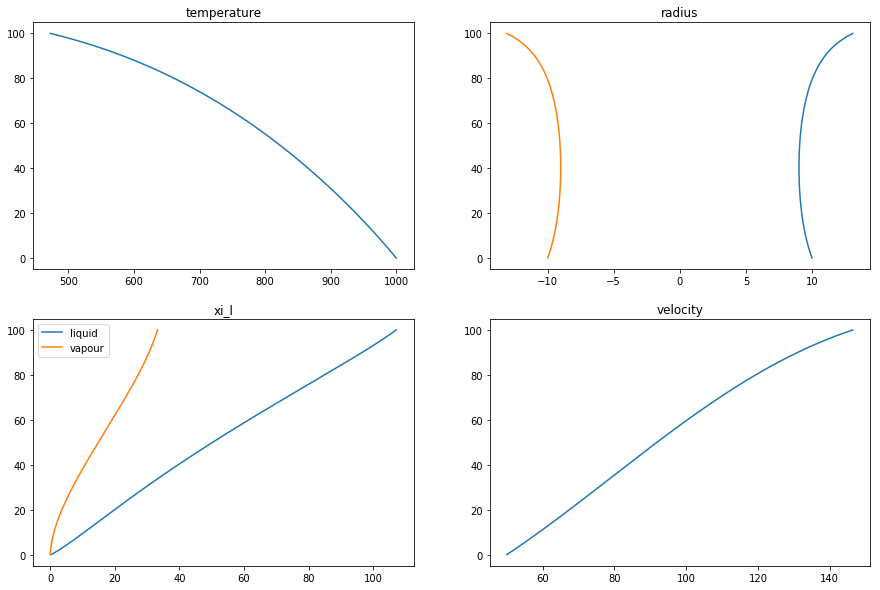

In [162]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

temp = np.array(s.temperature[1:])
axes[0][0].set_title('temperature')
axes[0][0].plot(temp, np.arange(0, s.h, s.step))

radius = s.radius
axes[0][1].set_title('radius')
axes[0][1].plot(radius, np.arange(0, s.h + s.step, s.step))
axes[0][1].plot([-1 * x for x in radius], np.arange(0, s.h + s.step, s.step))

xi_l = np.cumsum(s.xi_l_hist)
xi_v = np.cumsum(s.xi_v_hist)
axes[1][0].plot(xi_l, np.arange(0, s.h, s.step), label='liquid')
axes[1][0].plot(xi_v, np.arange(0, s.h, s.step), label='vapour')
axes[1][0].set_title('xi_l')
axes[1][0].legend()

velocity = s.velocity
axes[1][1].plot(velocity, np.arange(0, s.h + s.step, s.step))
axes[1][1].set_title('velocity')

plt.show()